In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split


2025-05-28 02:34:42.853319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748399683.191873      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748399683.299196      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
pd.set_option('display.max_rows', None)

In [3]:
param_dist = {
    'units': [32, 64, 128],              # số neuron mỗi layer
    'dropout': [0.2, 0.3, 0.5],          # dropout giữa các lớp
    'batch_size': [16, 32, 64],          # batch size khi huấn luyện
    'epochs': [10, 20, 30],              # số epoch huấn luyện
    'learning_rate': [0.001, 0.0005],    # tốc độ học
}


In [4]:
import os
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

def build_lstm_model(input_shape, num_classes, units=64, dropout=0.3):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_phase(phase_path, random_state=42, sample=False, units=64, dropout=0.3, batch_size=32, epochs=30):
    best_model = None
    best_score = 0
    all_metrics = []
    best_fold = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        # Reshape cho LSTM: (samples, timesteps=1, features)
        X_train_lstm = np.expand_dims(X_train_scaled.values, axis=1)
        X_val_lstm = np.expand_dims(X_val_scaled.values, axis=1)

        # Xử lý nhãn
        classes = np.unique(np.concatenate((y_train, y_val)))
        y_train_cat = to_categorical(np.searchsorted(classes, y_train), num_classes=len(classes))
        y_val_cat = to_categorical(np.searchsorted(classes, y_val), num_classes=len(classes))

        # Build model
        input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
        model = build_lstm_model(input_shape, num_classes=len(classes), units=units, dropout=dropout)

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(
            X_train_lstm, y_train_cat,
            validation_data=(X_val_lstm, y_val_cat),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=2
        )

        # Predict
        y_proba = model.predict(X_val_lstm)
        y_pred = np.argmax(y_proba, axis=1)
        y_val_idx = np.searchsorted(classes, y_val)

        acc = accuracy_score(y_val_idx, y_pred)
        f1 = f1_score(y_val_idx, y_pred, average='macro')
        y_val_bin = label_binarize(y_val_idx, classes=range(len(classes)))
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val_idx, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_val_idx, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Average metrics
    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    return best_model, best_scaler, best_fold, all_metrics




======= Training Phase 1 ========



2025-05-28 02:35:03.001691: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
340/340 - 17s - 49ms/step - accuracy: 0.6558 - loss: 1.0116 - val_accuracy: 0.6571 - val_loss: 0.8642
Epoch 2/30
340/340 - 3s - 9ms/step - accuracy: 0.6583 - loss: 0.8647 - val_accuracy: 0.6575 - val_loss: 0.8444
Epoch 3/30
340/340 - 3s - 8ms/step - accuracy: 0.6587 - loss: 0.8497 - val_accuracy: 0.6652 - val_loss: 0.8280
Epoch 4/30
340/340 - 3s - 8ms/step - accuracy: 0.6675 - loss: 0.8297 - val_accuracy: 0.6729 - val_loss: 0.8043
Epoch 5/30
340/340 - 3s - 8ms/step - accuracy: 0.6791 - loss: 0.8149 - val_accuracy: 0.6891 - val_loss: 0.7848
Epoch 6/30
340/340 - 3s - 8ms/step - accuracy: 0.6821 - loss: 0.8007 - val_accuracy: 0.6917 - val_loss: 0.7825
Epoch 7/30
340/340 - 3s - 8ms/step - accuracy: 0.6869 - loss: 0.7931 - val_accuracy: 0.6921 - val_loss: 0.7749
Epoch 8/30
340/340 - 3s - 8ms/step - accuracy: 0.6889 - loss: 0.7850 - val_accuracy: 0.6947 - val_loss: 0.7684
Epoch 9/30
340/340 - 3s - 8ms/step - accuracy: 0.6863 - loss: 0.7795 - val_accuracy: 0.6947 - val_loss: 0.7644

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


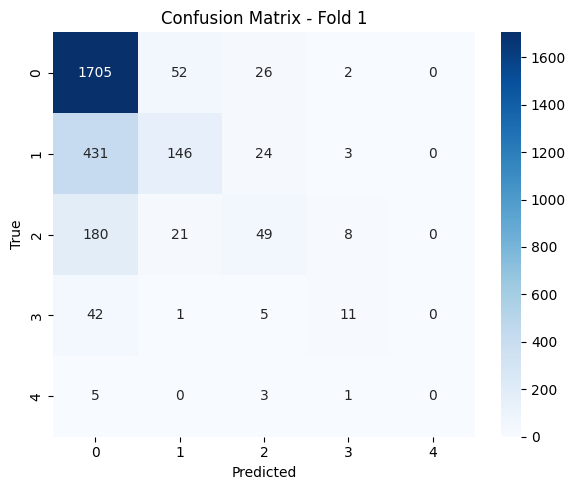

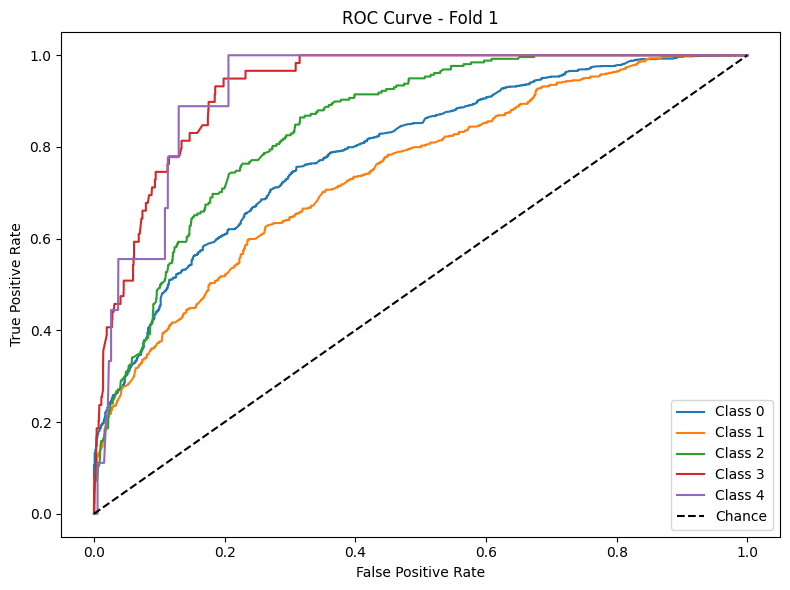

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 15s - 43ms/step - accuracy: 0.6552 - loss: 1.0007 - val_accuracy: 0.6581 - val_loss: 0.8732
Epoch 2/30
340/340 - 3s - 8ms/step - accuracy: 0.6583 - loss: 0.8613 - val_accuracy: 0.6581 - val_loss: 0.8537
Epoch 3/30
340/340 - 3s - 8ms/step - accuracy: 0.6606 - loss: 0.8422 - val_accuracy: 0.6584 - val_loss: 0.8267
Epoch 4/30
340/340 - 3s - 8ms/step - accuracy: 0.6677 - loss: 0.8225 - val_accuracy: 0.6831 - val_loss: 0.8148
Epoch 5/30
340/340 - 3s - 8ms/step - accuracy: 0.6780 - loss: 0.8096 - val_accuracy: 0.6783 - val_loss: 0.8090
Epoch 6/30
340/340 - 3s - 8ms/step - accuracy: 0.6811 - loss: 0.7994 - val_accuracy: 0.6861 - val_loss: 0.7997
Epoch 7/30
340/340 - 3s - 8ms/step - accuracy: 0.6874 - loss: 0.7934 - val_accuracy: 0.6835 - val_loss: 0.7970
Epoch 8/30
340/340 - 3s - 8ms/step - accuracy: 0.6878 - loss: 0.7838 - val_accuracy: 0.6887 - val_loss: 0.7867
Epoch 9/30
340/340 - 3s - 8ms/step - accuracy: 0.6925 - loss: 0.7756 - val_accuracy: 0.6909 - val_loss: 0.7780
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


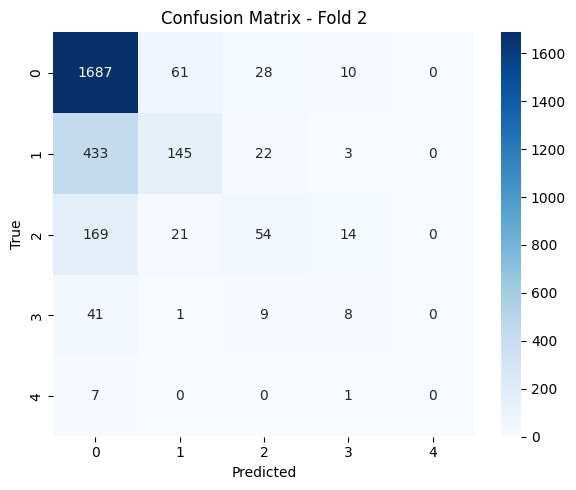

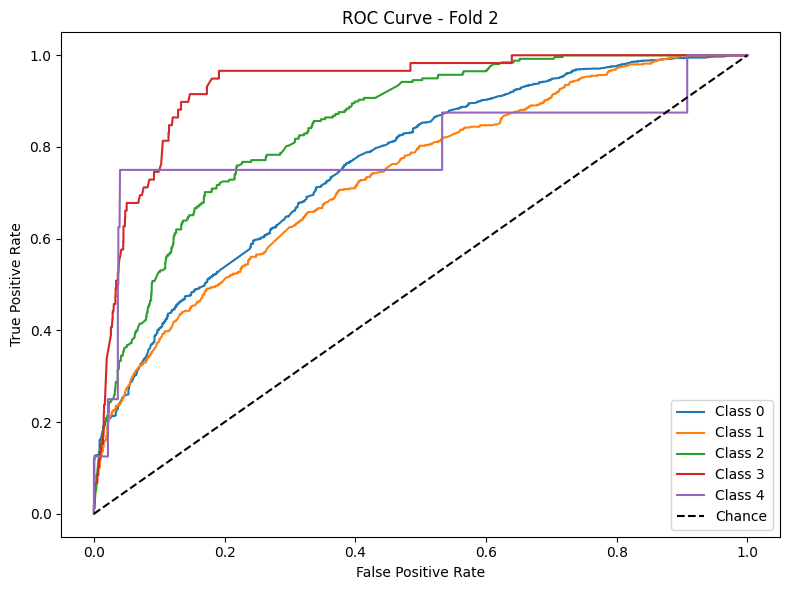

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
340/340 - 15s - 44ms/step - accuracy: 0.6562 - loss: 0.9961 - val_accuracy: 0.6581 - val_loss: 0.8612
Epoch 2/30
340/340 - 3s - 8ms/step - accuracy: 0.6580 - loss: 0.8660 - val_accuracy: 0.6581 - val_loss: 0.8418
Epoch 3/30
340/340 - 3s - 9ms/step - accuracy: 0.6593 - loss: 0.8534 - val_accuracy: 0.6581 - val_loss: 0.8349
Epoch 4/30
340/340 - 3s - 8ms/step - accuracy: 0.6634 - loss: 0.8341 - val_accuracy: 0.6662 - val_loss: 0.8127
Epoch 5/30
340/340 - 3s - 8ms/step - accuracy: 0.6749 - loss: 0.8204 - val_accuracy: 0.6721 - val_loss: 0.7953
Epoch 6/30
340/340 - 3s - 8ms/step - accuracy: 0.6797 - loss: 0.8091 - val_accuracy: 0.6728 - val_loss: 0.7891
Epoch 7/30
340/340 - 3s - 8ms/step - accuracy: 0.6831 - loss: 0.7977 - val_accuracy: 0.6824 - val_loss: 0.7829
Epoch 8/30
340/340 - 3s - 8ms/step - accuracy: 0.6849 - loss: 0.7874 - val_accuracy: 0.6857 - val_loss: 0.7722
Epoch 9/30
340/340 - 3s - 8ms/step - accuracy: 0.6861 - loss: 0.7827 - val_accuracy: 0.6809 - val_loss: 0.7665

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


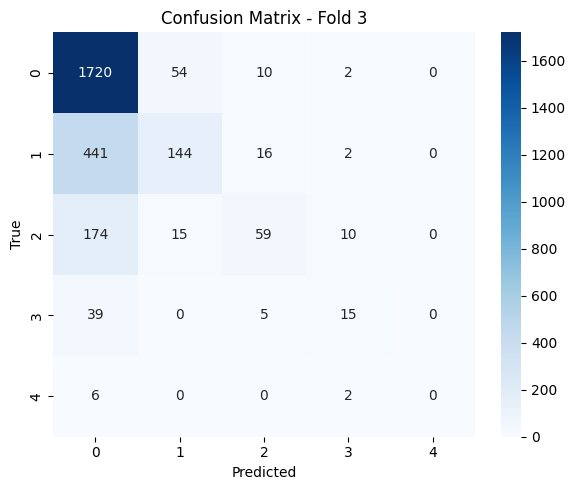

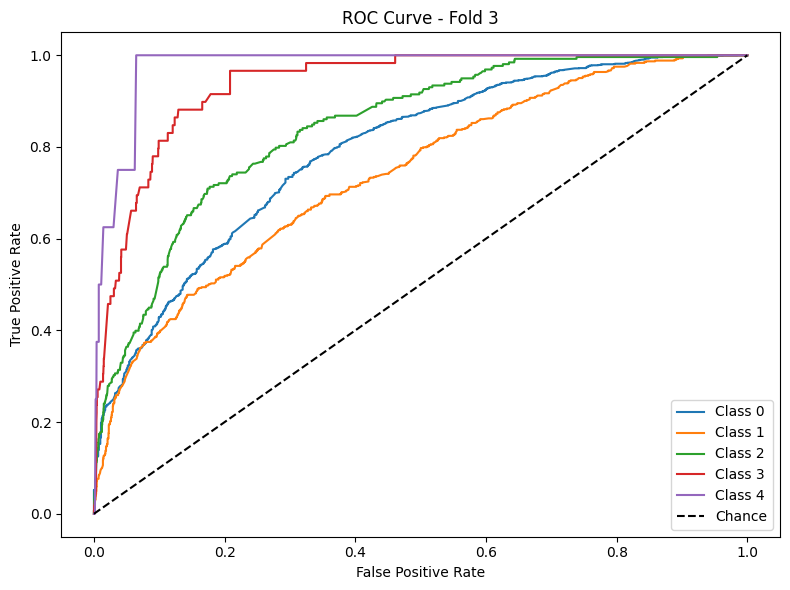

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
340/340 - 16s - 46ms/step - accuracy: 0.6564 - loss: 1.0011 - val_accuracy: 0.6577 - val_loss: 0.8597
Epoch 2/30
340/340 - 3s - 9ms/step - accuracy: 0.6583 - loss: 0.8674 - val_accuracy: 0.6577 - val_loss: 0.8464
Epoch 3/30
340/340 - 3s - 8ms/step - accuracy: 0.6588 - loss: 0.8546 - val_accuracy: 0.6577 - val_loss: 0.8317
Epoch 4/30
340/340 - 3s - 8ms/step - accuracy: 0.6601 - loss: 0.8421 - val_accuracy: 0.6614 - val_loss: 0.8213
Epoch 5/30
340/340 - 3s - 8ms/step - accuracy: 0.6672 - loss: 0.8294 - val_accuracy: 0.6654 - val_loss: 0.7978
Epoch 6/30
340/340 - 3s - 8ms/step - accuracy: 0.6732 - loss: 0.8147 - val_accuracy: 0.6835 - val_loss: 0.7804
Epoch 7/30
340/340 - 3s - 10ms/step - accuracy: 0.6780 - loss: 0.8035 - val_accuracy: 0.6909 - val_loss: 0.7715
Epoch 8/30
340/340 - 3s - 9ms/step - accuracy: 0.6809 - loss: 0.7948 - val_accuracy: 0.6945 - val_loss: 0.7603
Epoch 9/30
340/340 - 4s - 10ms/step - accuracy: 0.6822 - loss: 0.7897 - val_accuracy: 0.7027 - val_loss: 0.75

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


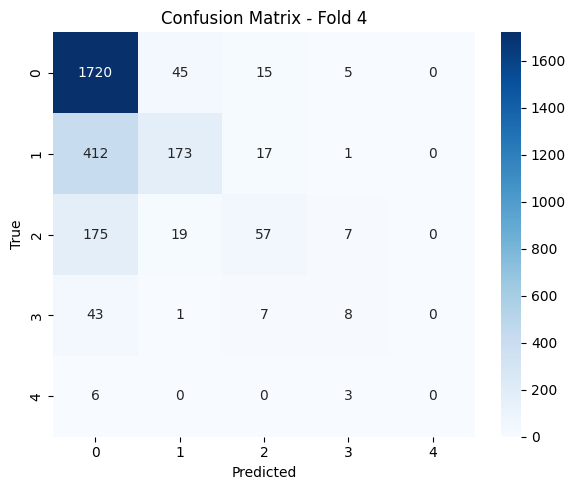

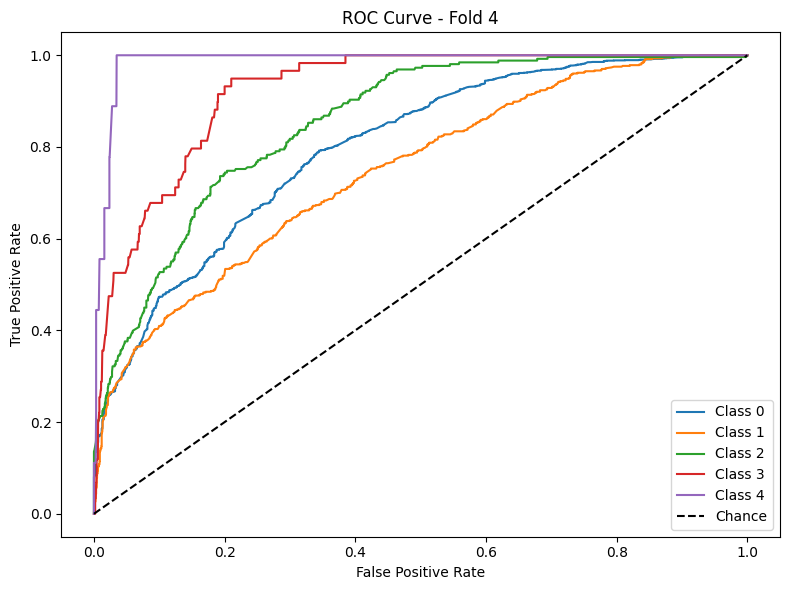

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
340/340 - 17s - 51ms/step - accuracy: 0.6562 - loss: 1.0075 - val_accuracy: 0.6577 - val_loss: 0.8665
Epoch 2/30
340/340 - 4s - 10ms/step - accuracy: 0.6578 - loss: 0.8673 - val_accuracy: 0.6577 - val_loss: 0.8501
Epoch 3/30
340/340 - 3s - 10ms/step - accuracy: 0.6607 - loss: 0.8441 - val_accuracy: 0.6809 - val_loss: 0.8144
Epoch 4/30
340/340 - 4s - 11ms/step - accuracy: 0.6712 - loss: 0.8234 - val_accuracy: 0.6861 - val_loss: 0.8019
Epoch 5/30
340/340 - 4s - 12ms/step - accuracy: 0.6785 - loss: 0.8093 - val_accuracy: 0.6817 - val_loss: 0.7936
Epoch 6/30
340/340 - 4s - 11ms/step - accuracy: 0.6793 - loss: 0.8020 - val_accuracy: 0.6901 - val_loss: 0.8049
Epoch 7/30
340/340 - 4s - 11ms/step - accuracy: 0.6837 - loss: 0.7965 - val_accuracy: 0.6868 - val_loss: 0.7794
Epoch 8/30
340/340 - 3s - 9ms/step - accuracy: 0.6862 - loss: 0.7912 - val_accuracy: 0.6916 - val_loss: 0.7713
Epoch 9/30
340/340 - 3s - 9ms/step - accuracy: 0.6886 - loss: 0.7813 - val_accuracy: 0.6912 - val_loss: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


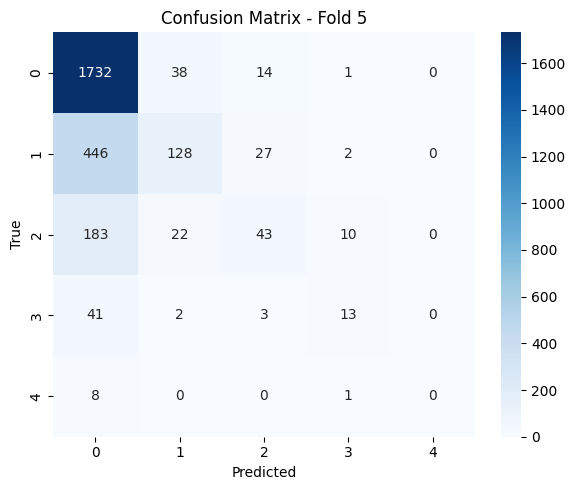

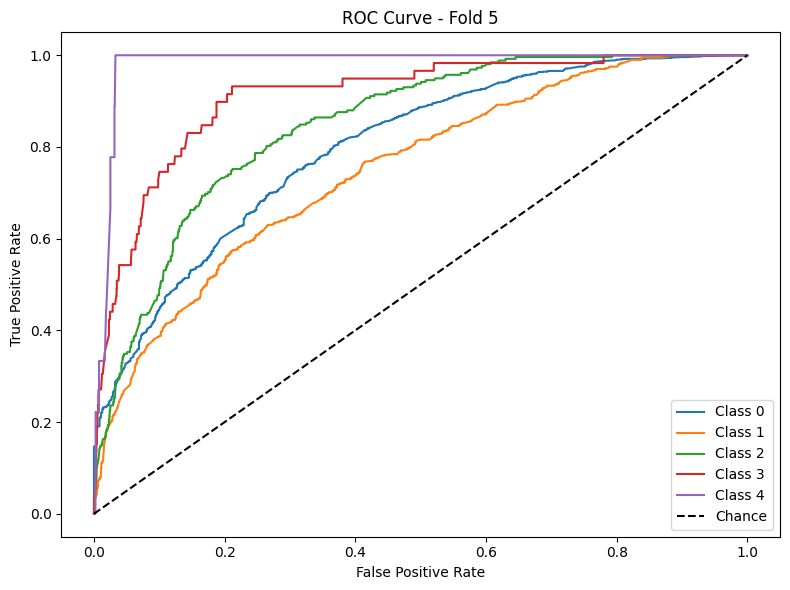


Average Accuracy: 0.7086
Average F1 Macro: 0.3457
Average AUC: 0.8476


======= Training Phase 2 ========



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
283/283 - 15s - 53ms/step - accuracy: 0.6573 - loss: 1.0272 - val_accuracy: 0.6588 - val_loss: 0.8814
Epoch 2/30
283/283 - 2s - 9ms/step - accuracy: 0.6597 - loss: 0.8716 - val_accuracy: 0.6588 - val_loss: 0.8734
Epoch 3/30
283/283 - 3s - 10ms/step - accuracy: 0.6608 - loss: 0.8583 - val_accuracy: 0.6593 - val_loss: 0.8576
Epoch 4/30
283/283 - 3s - 9ms/step - accuracy: 0.6614 - loss: 0.8436 - val_accuracy: 0.6602 - val_loss: 0.8494
Epoch 5/30
283/283 - 3s - 10ms/step - accuracy: 0.6615 - loss: 0.8425 - val_accuracy: 0.6602 - val_loss: 0.8362
Epoch 6/30
283/283 - 2s - 9ms/step - accuracy: 0.6626 - loss: 0.8319 - val_accuracy: 0.6624 - val_loss: 0.8228
Epoch 7/30
283/283 - 3s - 10ms/step - accuracy: 0.6744 - loss: 0.8180 - val_accuracy: 0.6748 - val_loss: 0.8014
Epoch 8/30
283/283 - 3s - 9ms/step - accuracy: 0.6777 - loss: 0.8017 - val_accuracy: 0.6783 - val_loss: 0.7973
Epoch 9/30
283/283 - 3s - 10ms/step - accuracy: 0.6812 - loss: 0.7988 - val_accuracy: 0.6827 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


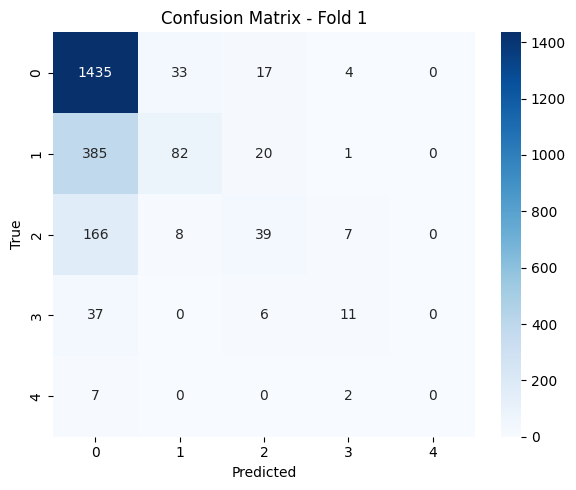

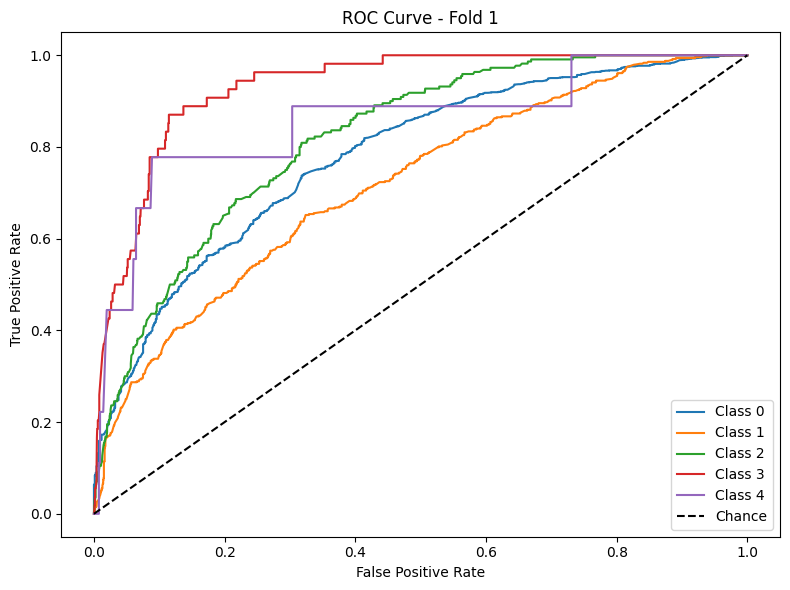

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 15s - 53ms/step - accuracy: 0.6555 - loss: 1.0236 - val_accuracy: 0.6588 - val_loss: 0.8765
Epoch 2/30
283/283 - 3s - 9ms/step - accuracy: 0.6592 - loss: 0.8797 - val_accuracy: 0.6628 - val_loss: 0.8558
Epoch 3/30
283/283 - 2s - 8ms/step - accuracy: 0.6600 - loss: 0.8632 - val_accuracy: 0.6611 - val_loss: 0.8491
Epoch 4/30
283/283 - 2s - 9ms/step - accuracy: 0.6609 - loss: 0.8525 - val_accuracy: 0.6597 - val_loss: 0.8381
Epoch 5/30
283/283 - 2s - 8ms/step - accuracy: 0.6613 - loss: 0.8447 - val_accuracy: 0.6642 - val_loss: 0.8282
Epoch 6/30
283/283 - 3s - 9ms/step - accuracy: 0.6612 - loss: 0.8407 - val_accuracy: 0.6611 - val_loss: 0.8199
Epoch 7/30
283/283 - 2s - 8ms/step - accuracy: 0.6667 - loss: 0.8206 - val_accuracy: 0.6695 - val_loss: 0.8018
Epoch 8/30
283/283 - 2s - 8ms/step - accuracy: 0.6722 - loss: 0.8099 - val_accuracy: 0.6796 - val_loss: 0.7855
Epoch 9/30
283/283 - 2s - 8ms/step - accuracy: 0.6801 - loss: 0.7991 - val_accuracy: 0.6810 - val_loss: 0.7769
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


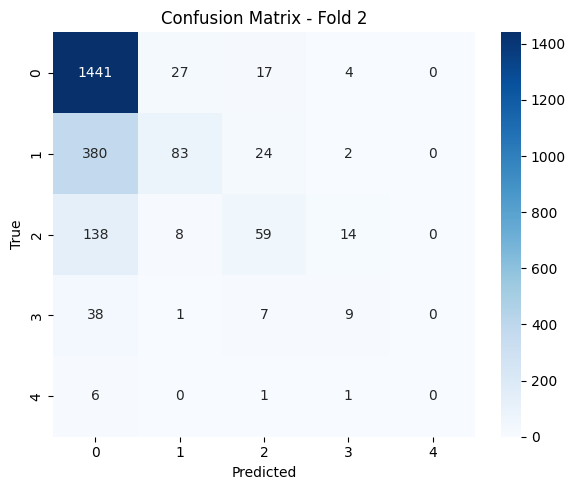

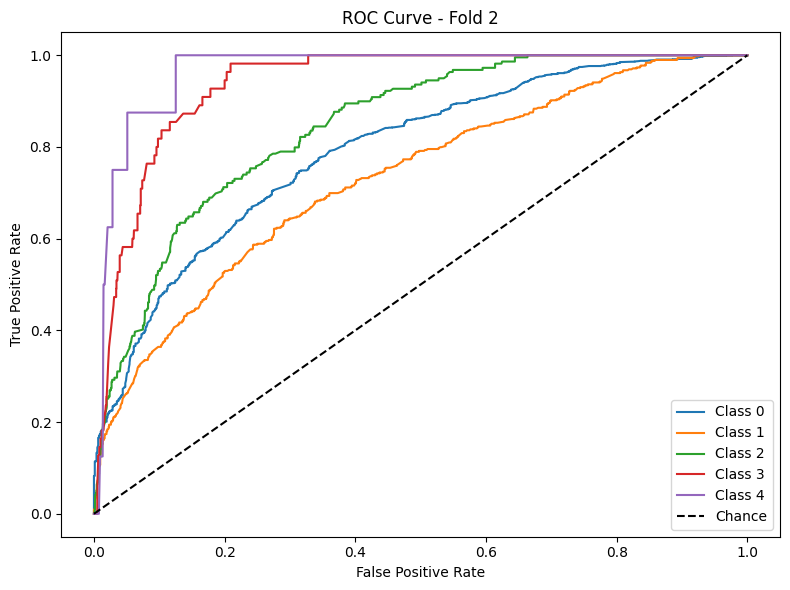

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 14s - 49ms/step - accuracy: 0.6567 - loss: 1.0245 - val_accuracy: 0.6591 - val_loss: 0.8727
Epoch 2/30
283/283 - 3s - 10ms/step - accuracy: 0.6598 - loss: 0.8767 - val_accuracy: 0.6591 - val_loss: 0.8596
Epoch 3/30
283/283 - 3s - 9ms/step - accuracy: 0.6594 - loss: 0.8596 - val_accuracy: 0.6636 - val_loss: 0.8506
Epoch 4/30
283/283 - 3s - 9ms/step - accuracy: 0.6600 - loss: 0.8503 - val_accuracy: 0.6636 - val_loss: 0.8464
Epoch 5/30
283/283 - 3s - 11ms/step - accuracy: 0.6628 - loss: 0.8406 - val_accuracy: 0.6627 - val_loss: 0.8307
Epoch 6/30
283/283 - 3s - 9ms/step - accuracy: 0.6694 - loss: 0.8279 - val_accuracy: 0.6729 - val_loss: 0.8117
Epoch 7/30
283/283 - 2s - 9ms/step - accuracy: 0.6789 - loss: 0.8054 - val_accuracy: 0.6813 - val_loss: 0.8042
Epoch 8/30
283/283 - 3s - 9ms/step - accuracy: 0.6805 - loss: 0.8031 - val_accuracy: 0.6755 - val_loss: 0.8004
Epoch 9/30
283/283 - 3s - 10ms/step - accuracy: 0.6837 - loss: 0.7911 - val_accuracy: 0.6848 - val_loss: 0.7944
Epoch 1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


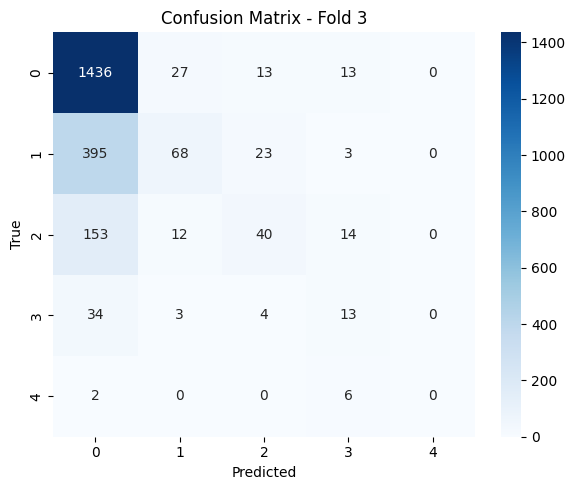

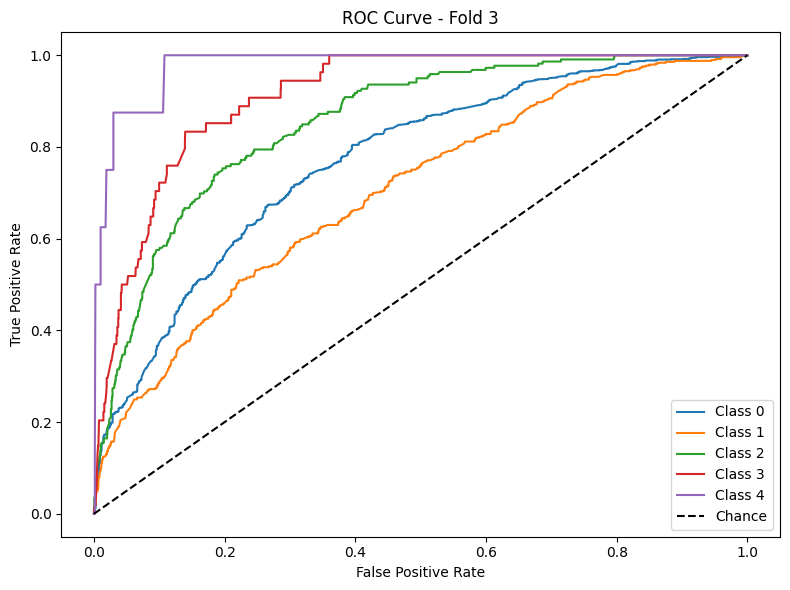

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
283/283 - 15s - 52ms/step - accuracy: 0.6578 - loss: 1.0315 - val_accuracy: 0.6609 - val_loss: 0.8729
Epoch 2/30
283/283 - 3s - 10ms/step - accuracy: 0.6597 - loss: 0.8747 - val_accuracy: 0.6649 - val_loss: 0.8669
Epoch 3/30
283/283 - 2s - 8ms/step - accuracy: 0.6605 - loss: 0.8581 - val_accuracy: 0.6605 - val_loss: 0.8498
Epoch 4/30
283/283 - 2s - 8ms/step - accuracy: 0.6612 - loss: 0.8512 - val_accuracy: 0.6600 - val_loss: 0.8490
Epoch 5/30
283/283 - 3s - 10ms/step - accuracy: 0.6625 - loss: 0.8461 - val_accuracy: 0.6609 - val_loss: 0.8395
Epoch 6/30
283/283 - 3s - 10ms/step - accuracy: 0.6620 - loss: 0.8362 - val_accuracy: 0.6596 - val_loss: 0.8363
Epoch 7/30
283/283 - 3s - 9ms/step - accuracy: 0.6625 - loss: 0.8318 - val_accuracy: 0.6614 - val_loss: 0.8352
Epoch 8/30
283/283 - 3s - 9ms/step - accuracy: 0.6633 - loss: 0.8222 - val_accuracy: 0.6698 - val_loss: 0.8073
Epoch 9/30
283/283 - 2s - 9ms/step - accuracy: 0.6735 - loss: 0.8090 - val_accuracy: 0.6795 - val_loss: 0.8

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


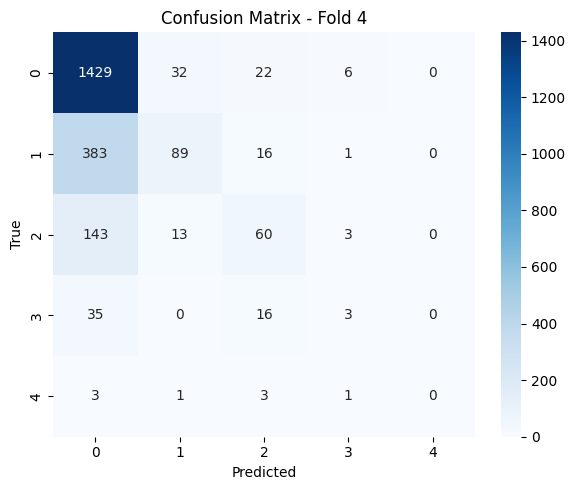

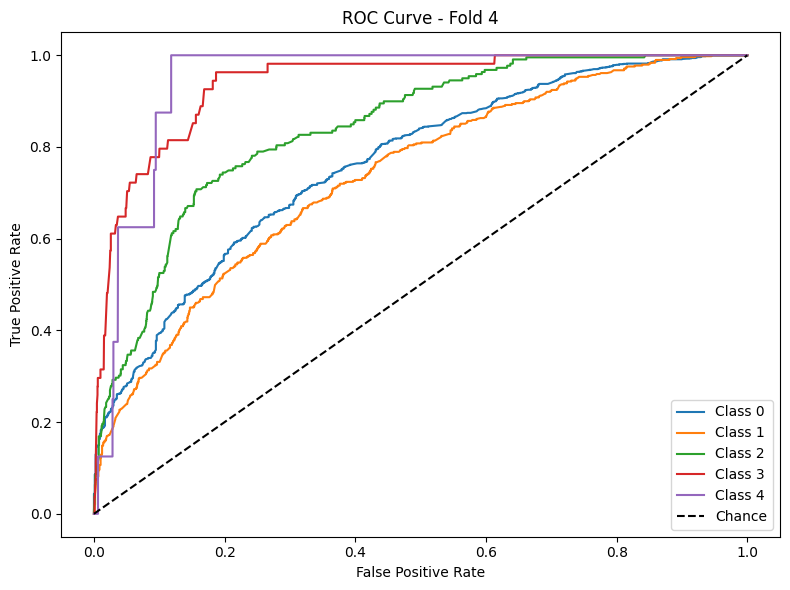

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
283/283 - 15s - 54ms/step - accuracy: 0.6570 - loss: 1.0228 - val_accuracy: 0.6596 - val_loss: 0.8716
Epoch 2/30
283/283 - 2s - 8ms/step - accuracy: 0.6593 - loss: 0.8770 - val_accuracy: 0.6596 - val_loss: 0.8465
Epoch 3/30
283/283 - 2s - 8ms/step - accuracy: 0.6605 - loss: 0.8587 - val_accuracy: 0.6596 - val_loss: 0.8404
Epoch 4/30
283/283 - 2s - 8ms/step - accuracy: 0.6609 - loss: 0.8508 - val_accuracy: 0.6605 - val_loss: 0.8334
Epoch 5/30
283/283 - 3s - 9ms/step - accuracy: 0.6624 - loss: 0.8388 - val_accuracy: 0.6596 - val_loss: 0.8210
Epoch 6/30
283/283 - 2s - 8ms/step - accuracy: 0.6702 - loss: 0.8223 - val_accuracy: 0.6768 - val_loss: 0.8008
Epoch 7/30
283/283 - 3s - 10ms/step - accuracy: 0.6735 - loss: 0.8108 - val_accuracy: 0.6804 - val_loss: 0.7995
Epoch 8/30
283/283 - 3s - 9ms/step - accuracy: 0.6766 - loss: 0.8018 - val_accuracy: 0.6822 - val_loss: 0.7932
Epoch 9/30
283/283 - 3s - 9ms/step - accuracy: 0.6823 - loss: 0.7941 - val_accuracy: 0.6875 - val_loss: 0.788

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


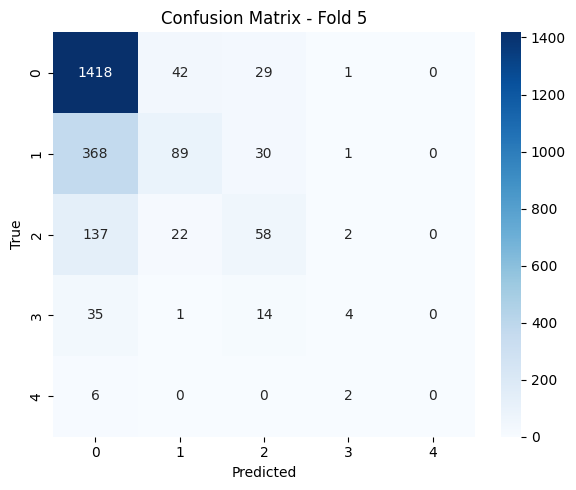

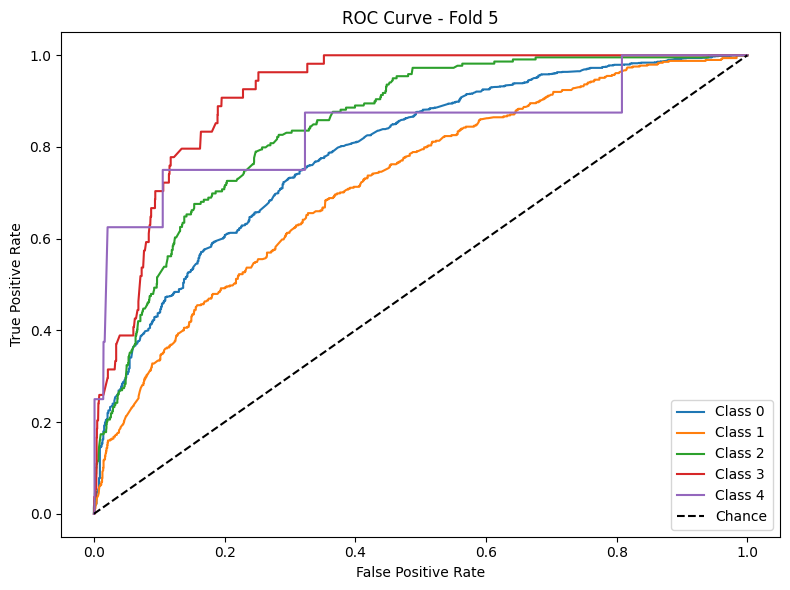


Average Accuracy: 0.6963
Average F1 Macro: 0.3185
Average AUC: 0.8373


======= Training Phase 3 ========



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
260/260 - 16s - 63ms/step - accuracy: 0.6544 - loss: 1.0544 - val_accuracy: 0.6562 - val_loss: 0.8854
Epoch 2/30
260/260 - 2s - 9ms/step - accuracy: 0.6557 - loss: 0.8870 - val_accuracy: 0.6562 - val_loss: 0.8706
Epoch 3/30
260/260 - 2s - 8ms/step - accuracy: 0.6564 - loss: 0.8681 - val_accuracy: 0.6562 - val_loss: 0.8491
Epoch 4/30
260/260 - 2s - 8ms/step - accuracy: 0.6571 - loss: 0.8588 - val_accuracy: 0.6620 - val_loss: 0.8400
Epoch 5/30
260/260 - 2s - 9ms/step - accuracy: 0.6576 - loss: 0.8491 - val_accuracy: 0.6606 - val_loss: 0.8308
Epoch 6/30
260/260 - 2s - 9ms/step - accuracy: 0.6597 - loss: 0.8386 - val_accuracy: 0.6610 - val_loss: 0.8241
Epoch 7/30
260/260 - 2s - 9ms/step - accuracy: 0.6588 - loss: 0.8314 - val_accuracy: 0.6581 - val_loss: 0.8234
Epoch 8/30
260/260 - 2s - 9ms/step - accuracy: 0.6603 - loss: 0.8196 - val_accuracy: 0.6572 - val_loss: 0.7996
Epoch 9/30
260/260 - 2s - 9ms/step - accuracy: 0.6655 - loss: 0.8126 - val_accuracy: 0.6774 - val_loss: 0.7850

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


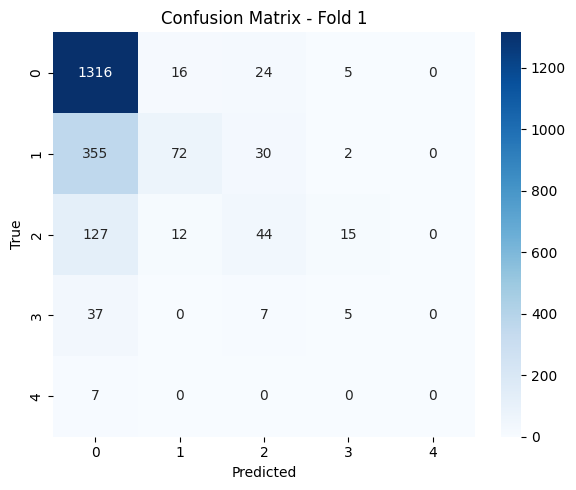

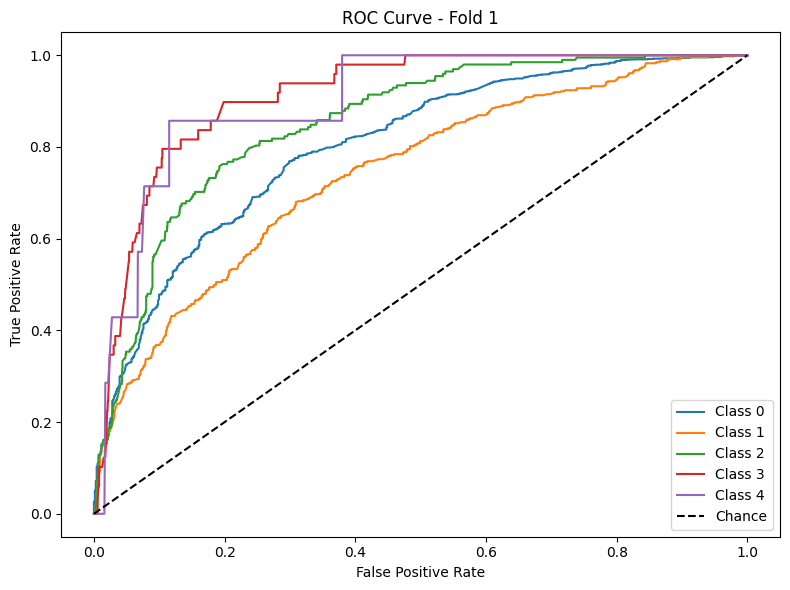

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 16s - 60ms/step - accuracy: 0.6540 - loss: 1.0421 - val_accuracy: 0.6557 - val_loss: 0.8821
Epoch 2/30
260/260 - 2s - 8ms/step - accuracy: 0.6563 - loss: 0.8856 - val_accuracy: 0.6557 - val_loss: 0.8588
Epoch 3/30
260/260 - 2s - 9ms/step - accuracy: 0.6563 - loss: 0.8693 - val_accuracy: 0.6557 - val_loss: 0.8492
Epoch 4/30
260/260 - 2s - 9ms/step - accuracy: 0.6569 - loss: 0.8564 - val_accuracy: 0.6567 - val_loss: 0.8431
Epoch 5/30
260/260 - 3s - 10ms/step - accuracy: 0.6586 - loss: 0.8489 - val_accuracy: 0.6562 - val_loss: 0.8311
Epoch 6/30
260/260 - 2s - 9ms/step - accuracy: 0.6587 - loss: 0.8369 - val_accuracy: 0.6548 - val_loss: 0.8284
Epoch 7/30
260/260 - 2s - 9ms/step - accuracy: 0.6624 - loss: 0.8238 - val_accuracy: 0.6663 - val_loss: 0.8091
Epoch 8/30
260/260 - 2s - 9ms/step - accuracy: 0.6708 - loss: 0.8110 - val_accuracy: 0.6750 - val_loss: 0.7934
Epoch 9/30
260/260 - 3s - 10ms/step - accuracy: 0.6776 - loss: 0.7972 - val_accuracy: 0.6731 - val_loss: 0.7866
Epoch 10

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


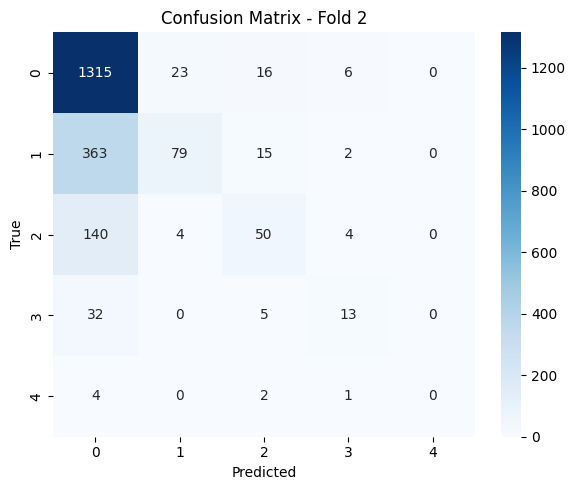

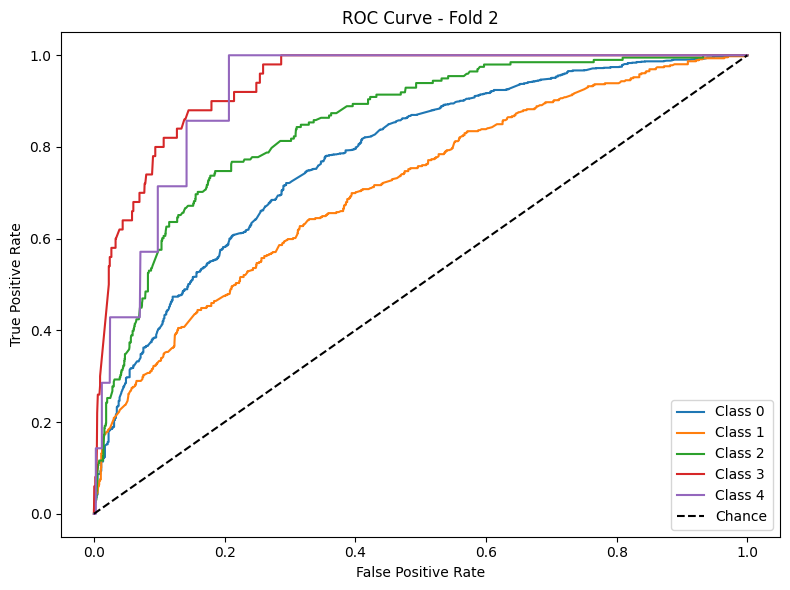

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
260/260 - 16s - 61ms/step - accuracy: 0.6532 - loss: 1.0503 - val_accuracy: 0.6553 - val_loss: 0.8848
Epoch 2/30
260/260 - 2s - 10ms/step - accuracy: 0.6559 - loss: 0.8812 - val_accuracy: 0.6562 - val_loss: 0.8598
Epoch 3/30
260/260 - 2s - 9ms/step - accuracy: 0.6561 - loss: 0.8627 - val_accuracy: 0.6553 - val_loss: 0.8543
Epoch 4/30
260/260 - 3s - 11ms/step - accuracy: 0.6573 - loss: 0.8506 - val_accuracy: 0.6557 - val_loss: 0.8432
Epoch 5/30
260/260 - 3s - 10ms/step - accuracy: 0.6576 - loss: 0.8394 - val_accuracy: 0.6591 - val_loss: 0.8336
Epoch 6/30
260/260 - 3s - 10ms/step - accuracy: 0.6602 - loss: 0.8314 - val_accuracy: 0.6586 - val_loss: 0.8210
Epoch 7/30
260/260 - 3s - 10ms/step - accuracy: 0.6674 - loss: 0.8164 - val_accuracy: 0.6765 - val_loss: 0.7995
Epoch 8/30
260/260 - 3s - 11ms/step - accuracy: 0.6751 - loss: 0.8021 - val_accuracy: 0.6866 - val_loss: 0.7862
Epoch 9/30
260/260 - 3s - 12ms/step - accuracy: 0.6773 - loss: 0.7915 - val_accuracy: 0.6818 - val_loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


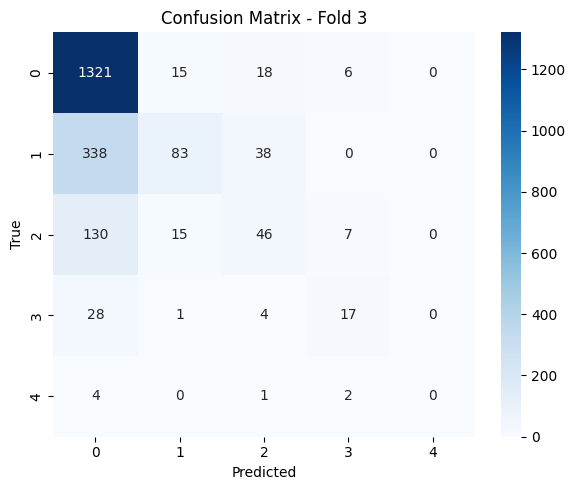

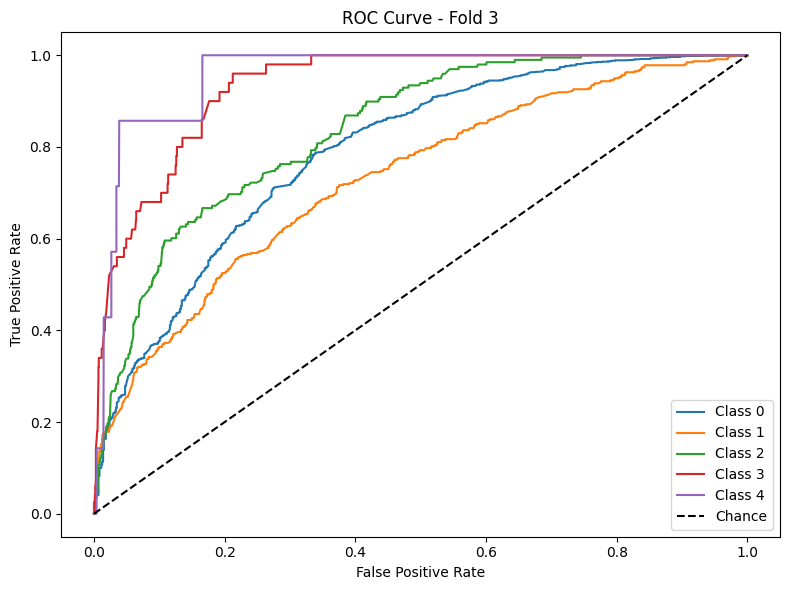

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
260/260 - 17s - 64ms/step - accuracy: 0.6544 - loss: 1.0426 - val_accuracy: 0.6557 - val_loss: 0.8828
Epoch 2/30
260/260 - 2s - 9ms/step - accuracy: 0.6558 - loss: 0.8798 - val_accuracy: 0.6557 - val_loss: 0.8638
Epoch 3/30
260/260 - 2s - 9ms/step - accuracy: 0.6569 - loss: 0.8652 - val_accuracy: 0.6557 - val_loss: 0.8522
Epoch 4/30
260/260 - 2s - 9ms/step - accuracy: 0.6579 - loss: 0.8529 - val_accuracy: 0.6567 - val_loss: 0.8499
Epoch 5/30
260/260 - 2s - 9ms/step - accuracy: 0.6575 - loss: 0.8425 - val_accuracy: 0.6562 - val_loss: 0.8396
Epoch 6/30
260/260 - 2s - 9ms/step - accuracy: 0.6590 - loss: 0.8299 - val_accuracy: 0.6586 - val_loss: 0.8333
Epoch 7/30
260/260 - 2s - 9ms/step - accuracy: 0.6626 - loss: 0.8201 - val_accuracy: 0.6688 - val_loss: 0.8200
Epoch 8/30
260/260 - 3s - 10ms/step - accuracy: 0.6731 - loss: 0.8054 - val_accuracy: 0.6707 - val_loss: 0.8099
Epoch 9/30
260/260 - 3s - 10ms/step - accuracy: 0.6792 - loss: 0.7911 - val_accuracy: 0.6760 - val_loss: 0.80

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


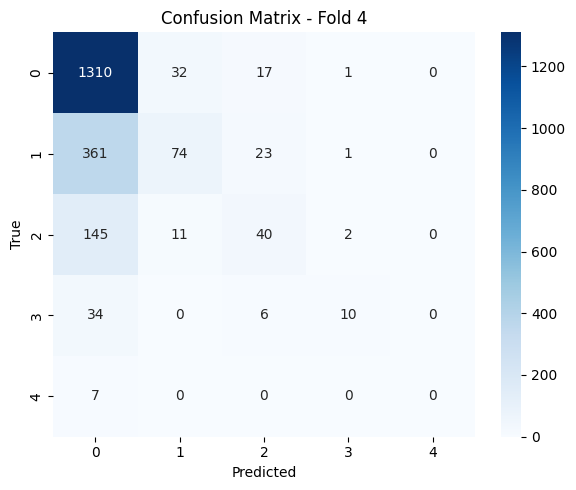

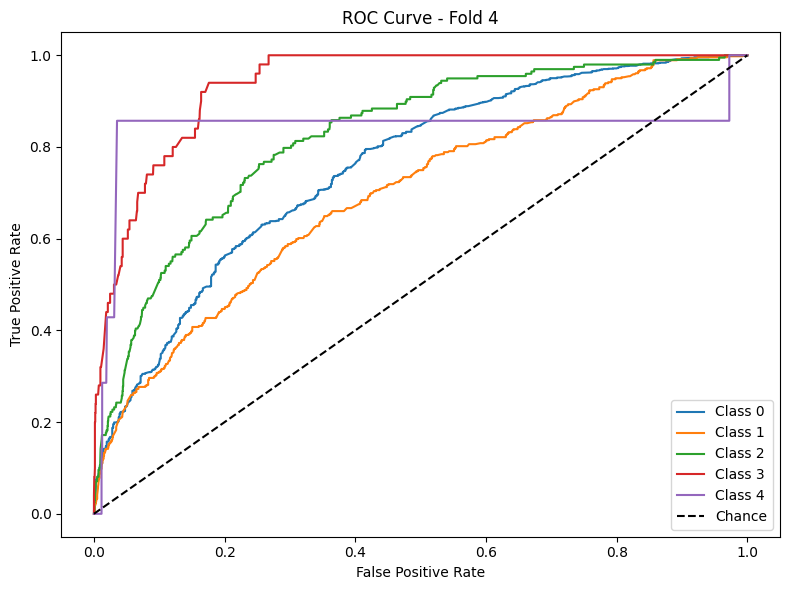

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
260/260 - 17s - 67ms/step - accuracy: 0.6537 - loss: 1.0374 - val_accuracy: 0.6561 - val_loss: 0.8954
Epoch 2/30
260/260 - 2s - 9ms/step - accuracy: 0.6562 - loss: 0.8797 - val_accuracy: 0.6565 - val_loss: 0.8686
Epoch 3/30
260/260 - 3s - 10ms/step - accuracy: 0.6569 - loss: 0.8618 - val_accuracy: 0.6561 - val_loss: 0.8564
Epoch 4/30
260/260 - 2s - 9ms/step - accuracy: 0.6563 - loss: 0.8540 - val_accuracy: 0.6565 - val_loss: 0.8506
Epoch 5/30
260/260 - 3s - 10ms/step - accuracy: 0.6577 - loss: 0.8401 - val_accuracy: 0.6561 - val_loss: 0.8375
Epoch 6/30
260/260 - 2s - 9ms/step - accuracy: 0.6574 - loss: 0.8344 - val_accuracy: 0.6575 - val_loss: 0.8280
Epoch 7/30
260/260 - 2s - 9ms/step - accuracy: 0.6597 - loss: 0.8206 - val_accuracy: 0.6556 - val_loss: 0.8287
Epoch 8/30
260/260 - 2s - 8ms/step - accuracy: 0.6731 - loss: 0.8030 - val_accuracy: 0.6734 - val_loss: 0.8102
Epoch 9/30
260/260 - 2s - 10ms/step - accuracy: 0.6791 - loss: 0.7878 - val_accuracy: 0.6725 - val_loss: 0.8

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


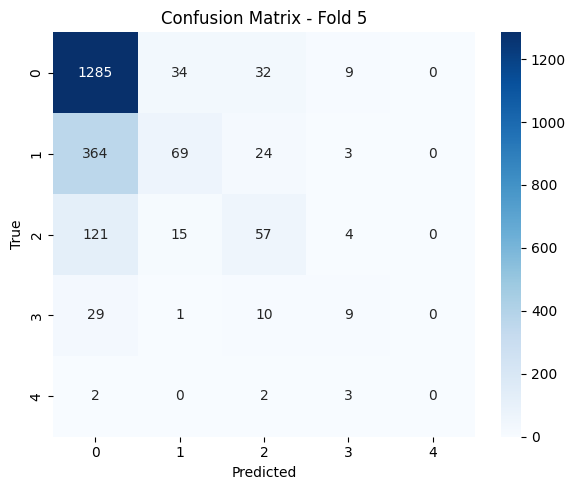

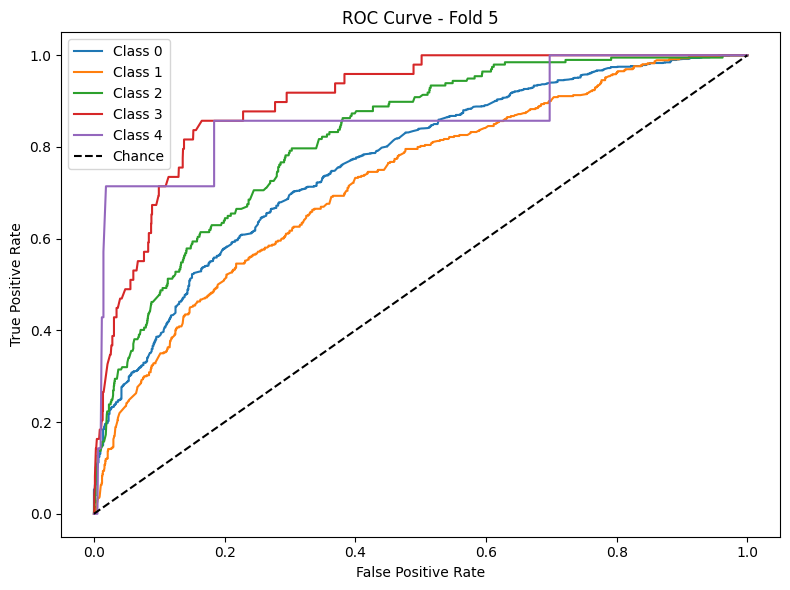


Average Accuracy: 0.6958
Average F1 Macro: 0.3373
Average AUC: 0.8318


======= Training Phase 4 ========



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
193/193 - 14s - 72ms/step - accuracy: 0.6462 - loss: 1.0983 - val_accuracy: 0.6498 - val_loss: 0.9128
Epoch 2/30
193/193 - 2s - 8ms/step - accuracy: 0.6493 - loss: 0.8985 - val_accuracy: 0.6491 - val_loss: 0.8872
Epoch 3/30
193/193 - 2s - 11ms/step - accuracy: 0.6506 - loss: 0.8813 - val_accuracy: 0.6498 - val_loss: 0.8656
Epoch 4/30
193/193 - 2s - 9ms/step - accuracy: 0.6508 - loss: 0.8641 - val_accuracy: 0.6517 - val_loss: 0.8603
Epoch 5/30
193/193 - 2s - 9ms/step - accuracy: 0.6531 - loss: 0.8491 - val_accuracy: 0.6517 - val_loss: 0.8436
Epoch 6/30
193/193 - 2s - 9ms/step - accuracy: 0.6534 - loss: 0.8344 - val_accuracy: 0.6504 - val_loss: 0.8326
Epoch 7/30
193/193 - 2s - 9ms/step - accuracy: 0.6731 - loss: 0.8213 - val_accuracy: 0.6777 - val_loss: 0.8096
Epoch 8/30
193/193 - 2s - 11ms/step - accuracy: 0.6807 - loss: 0.7982 - val_accuracy: 0.6907 - val_loss: 0.7951
Epoch 9/30
193/193 - 2s - 10ms/step - accuracy: 0.6870 - loss: 0.7833 - val_accuracy: 0.6771 - val_loss: 0.7

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


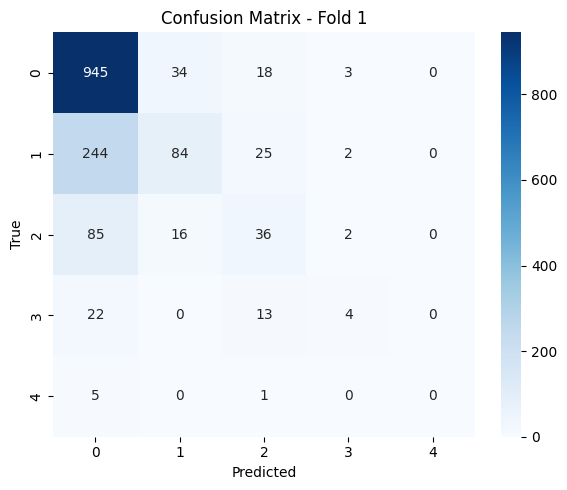

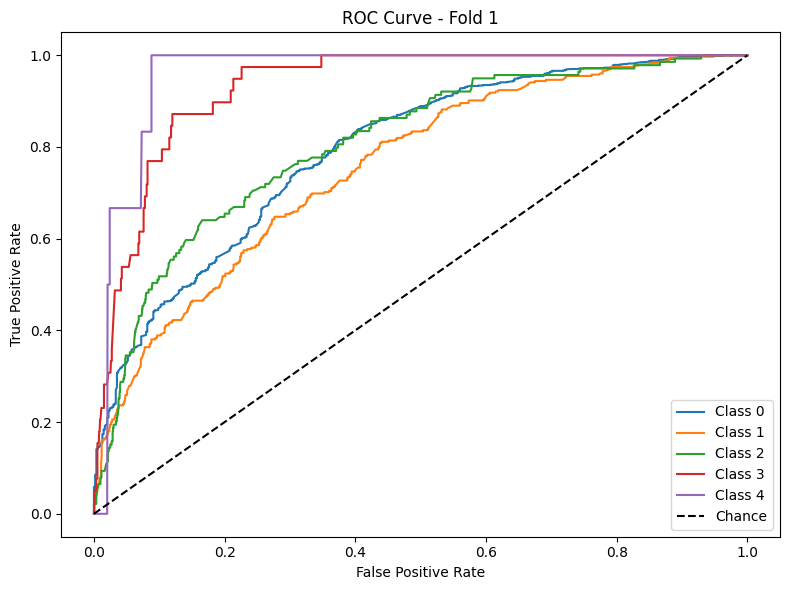

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 15s - 78ms/step - accuracy: 0.6461 - loss: 1.0975 - val_accuracy: 0.6498 - val_loss: 0.9053
Epoch 2/30
193/193 - 2s - 8ms/step - accuracy: 0.6492 - loss: 0.8981 - val_accuracy: 0.6498 - val_loss: 0.8768
Epoch 3/30
193/193 - 2s - 8ms/step - accuracy: 0.6492 - loss: 0.8758 - val_accuracy: 0.6504 - val_loss: 0.8621
Epoch 4/30
193/193 - 2s - 8ms/step - accuracy: 0.6505 - loss: 0.8563 - val_accuracy: 0.6556 - val_loss: 0.8492
Epoch 5/30
193/193 - 2s - 8ms/step - accuracy: 0.6568 - loss: 0.8345 - val_accuracy: 0.6738 - val_loss: 0.8290
Epoch 6/30
193/193 - 2s - 8ms/step - accuracy: 0.6781 - loss: 0.8092 - val_accuracy: 0.6881 - val_loss: 0.8067
Epoch 7/30
193/193 - 2s - 8ms/step - accuracy: 0.6776 - loss: 0.7992 - val_accuracy: 0.6823 - val_loss: 0.8001
Epoch 8/30
193/193 - 2s - 8ms/step - accuracy: 0.6805 - loss: 0.7845 - val_accuracy: 0.6764 - val_loss: 0.7874
Epoch 9/30
193/193 - 2s - 9ms/step - accuracy: 0.6904 - loss: 0.7792 - val_accuracy: 0.6862 - val_loss: 0.7777
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


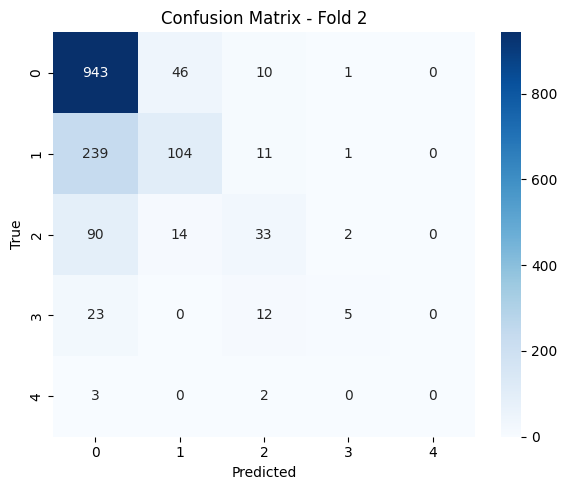

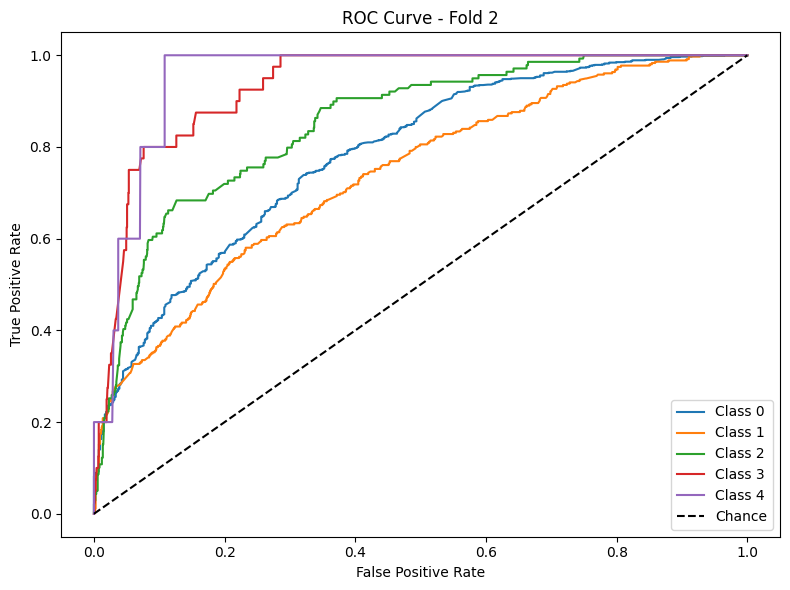

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
193/193 - 13s - 66ms/step - accuracy: 0.6471 - loss: 1.0910 - val_accuracy: 0.6491 - val_loss: 0.9117
Epoch 2/30
193/193 - 2s - 8ms/step - accuracy: 0.6493 - loss: 0.8939 - val_accuracy: 0.6491 - val_loss: 0.8851
Epoch 3/30
193/193 - 2s - 9ms/step - accuracy: 0.6506 - loss: 0.8712 - val_accuracy: 0.6511 - val_loss: 0.8696
Epoch 4/30
193/193 - 2s - 12ms/step - accuracy: 0.6513 - loss: 0.8555 - val_accuracy: 0.6537 - val_loss: 0.8557
Epoch 5/30
193/193 - 2s - 8ms/step - accuracy: 0.6519 - loss: 0.8444 - val_accuracy: 0.6543 - val_loss: 0.8499
Epoch 6/30
193/193 - 2s - 8ms/step - accuracy: 0.6547 - loss: 0.8328 - val_accuracy: 0.6563 - val_loss: 0.8356
Epoch 7/30
193/193 - 1s - 8ms/step - accuracy: 0.6584 - loss: 0.8172 - val_accuracy: 0.6758 - val_loss: 0.8317
Epoch 8/30
193/193 - 1s - 8ms/step - accuracy: 0.6740 - loss: 0.8005 - val_accuracy: 0.6836 - val_loss: 0.8074
Epoch 9/30
193/193 - 2s - 8ms/step - accuracy: 0.6849 - loss: 0.7881 - val_accuracy: 0.6790 - val_loss: 0.803

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


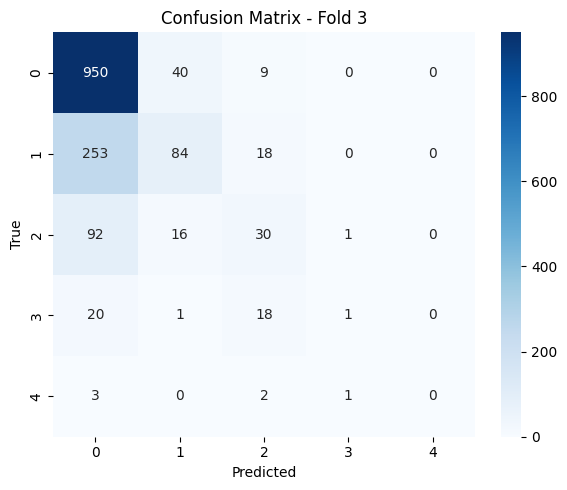

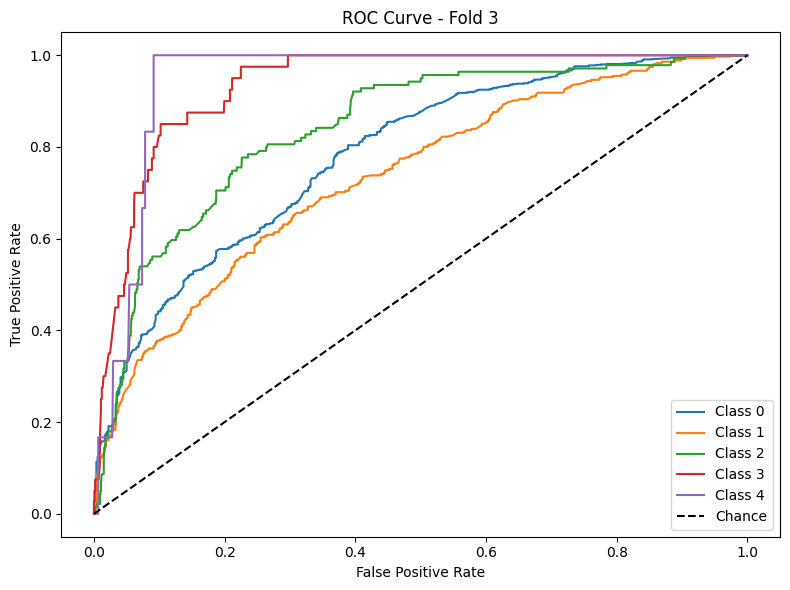

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 15s - 77ms/step - accuracy: 0.6470 - loss: 1.1081 - val_accuracy: 0.6495 - val_loss: 0.9025
Epoch 2/30
193/193 - 2s - 8ms/step - accuracy: 0.6496 - loss: 0.8991 - val_accuracy: 0.6502 - val_loss: 0.8617
Epoch 3/30
193/193 - 2s - 9ms/step - accuracy: 0.6499 - loss: 0.8779 - val_accuracy: 0.6502 - val_loss: 0.8521
Epoch 4/30
193/193 - 2s - 9ms/step - accuracy: 0.6502 - loss: 0.8602 - val_accuracy: 0.6502 - val_loss: 0.8414
Epoch 5/30
193/193 - 2s - 8ms/step - accuracy: 0.6520 - loss: 0.8447 - val_accuracy: 0.6521 - val_loss: 0.8279
Epoch 6/30
193/193 - 2s - 8ms/step - accuracy: 0.6525 - loss: 0.8345 - val_accuracy: 0.6528 - val_loss: 0.8282
Epoch 7/30
193/193 - 2s - 8ms/step - accuracy: 0.6574 - loss: 0.8254 - val_accuracy: 0.6534 - val_loss: 0.8247
Epoch 8/30
193/193 - 2s - 8ms/step - accuracy: 0.6791 - loss: 0.7978 - val_accuracy: 0.6743 - val_loss: 0.8051
Epoch 9/30
193/193 - 2s - 9ms/step - accuracy: 0.6827 - loss: 0.7867 - val_accuracy: 0.6736 - val_loss: 0.7955
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


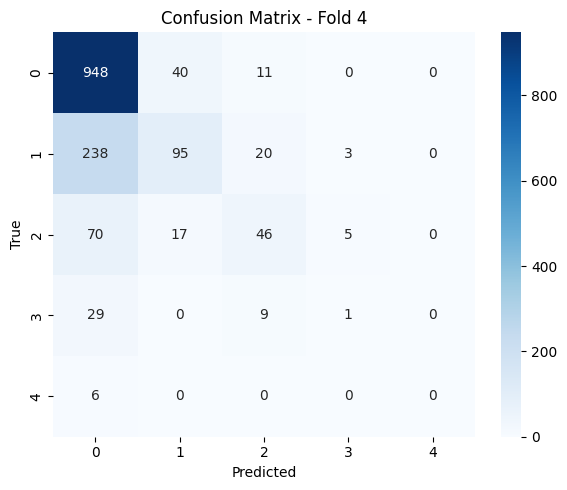

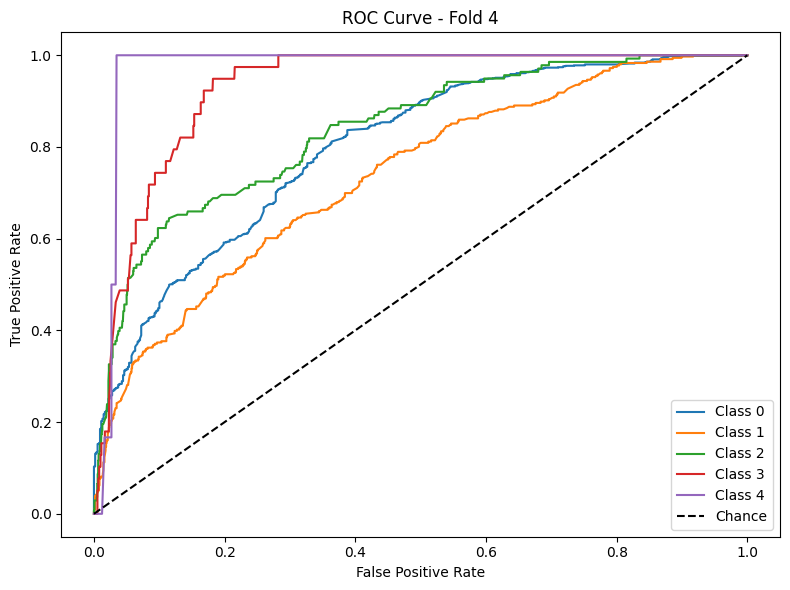

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
193/193 - 14s - 73ms/step - accuracy: 0.6444 - loss: 1.1140 - val_accuracy: 0.6495 - val_loss: 0.8983
Epoch 2/30
193/193 - 2s - 8ms/step - accuracy: 0.6496 - loss: 0.9010 - val_accuracy: 0.6502 - val_loss: 0.8669
Epoch 3/30
193/193 - 2s - 9ms/step - accuracy: 0.6496 - loss: 0.8808 - val_accuracy: 0.6502 - val_loss: 0.8574
Epoch 4/30
193/193 - 2s - 9ms/step - accuracy: 0.6494 - loss: 0.8630 - val_accuracy: 0.6495 - val_loss: 0.8512
Epoch 5/30
193/193 - 2s - 11ms/step - accuracy: 0.6504 - loss: 0.8494 - val_accuracy: 0.6521 - val_loss: 0.8342
Epoch 6/30
193/193 - 2s - 11ms/step - accuracy: 0.6570 - loss: 0.8364 - val_accuracy: 0.6541 - val_loss: 0.8207
Epoch 7/30
193/193 - 2s - 8ms/step - accuracy: 0.6639 - loss: 0.8250 - val_accuracy: 0.6873 - val_loss: 0.8092
Epoch 8/30
193/193 - 2s - 9ms/step - accuracy: 0.6715 - loss: 0.8132 - val_accuracy: 0.6925 - val_loss: 0.7929
Epoch 9/30
193/193 - 2s - 8ms/step - accuracy: 0.6827 - loss: 0.7903 - val_accuracy: 0.6821 - val_loss: 0.78

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


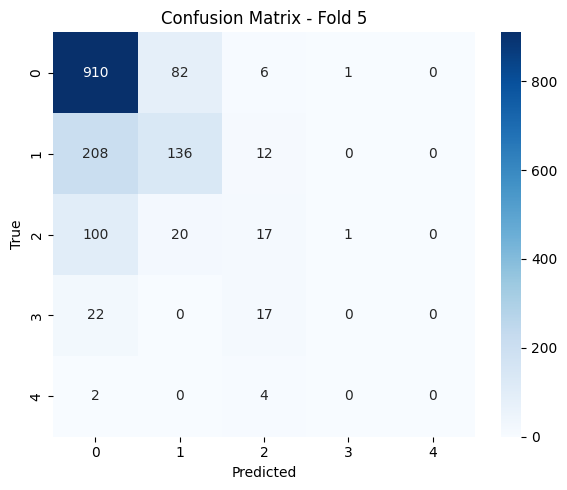

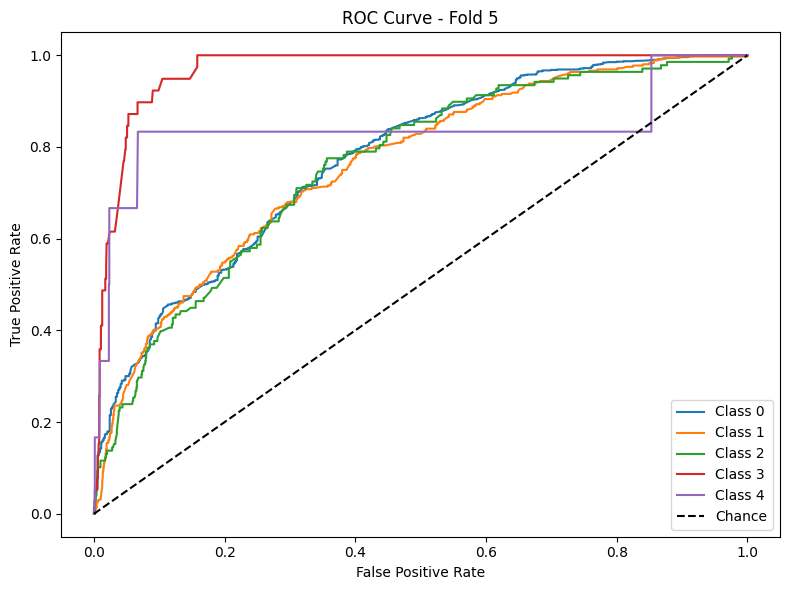


Average Accuracy: 0.6983
Average F1 Macro: 0.3185
Average AUC: 0.8444


In [5]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"

    # ✅ Lưu mô hình LSTM bằng Keras
    model.save(f"best_model_{temp}_phase{i}.h5")

    # ✅ Lưu scaler bằng joblib (vẫn đúng)
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")

    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = load_model(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded'].values
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Reshape for LSTM (samples, timesteps=1, features)
    X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

    # Predict
    y_proba = model.predict(X_test_lstm)
    y_pred = np.argmax(y_proba, axis=1)

    # Extract classes from y_test (sorted and unique)
    classes = np.unique(np.concatenate((y_test, y_pred)))

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, labels=classes))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.92       568
           1       0.32      0.19      0.24        63
           2       0.23      0.16      0.19        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.81       698
   macro avg       0.28      0.26      0.27       698
weighted avg       0.75      0.81      0.78       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


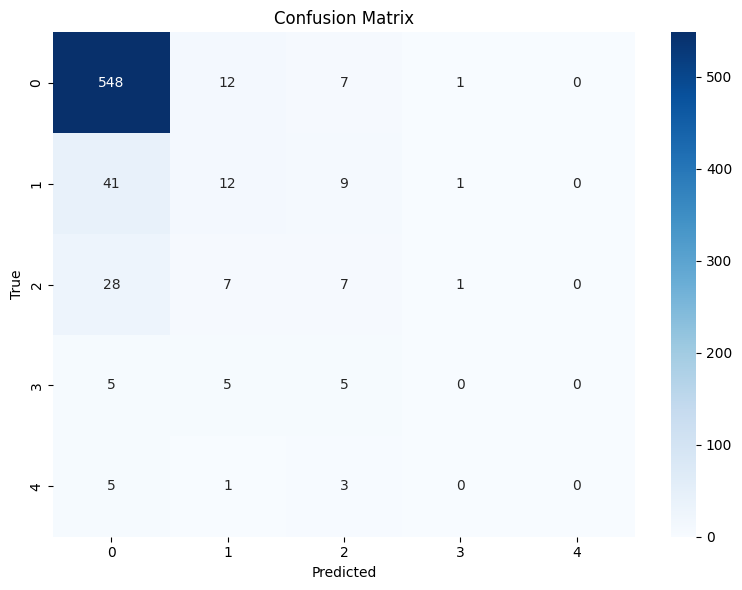


Test AUC (macro-average, OVR): 0.7351


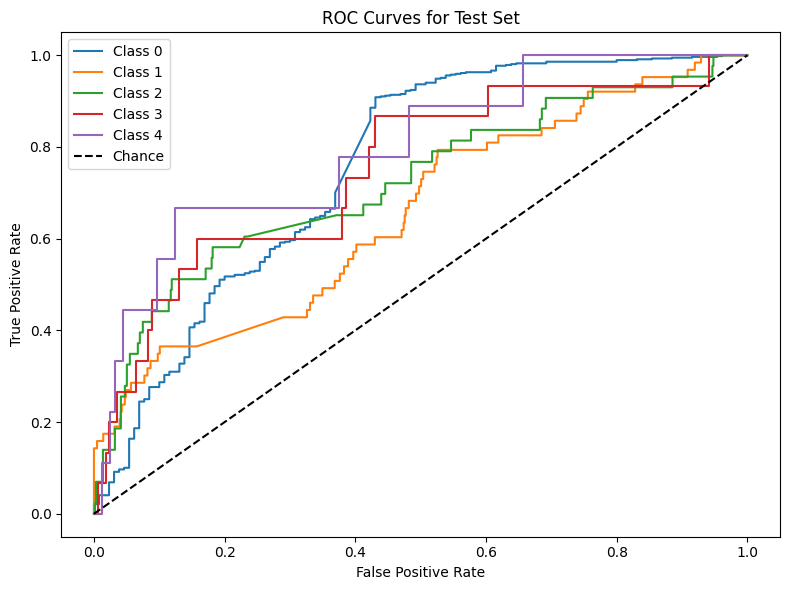

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       544
           1       0.31      0.20      0.24        59
           2       0.36      0.24      0.29        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.82       668
   macro avg       0.31      0.28      0.29       668
weighted avg       0.77      0.82      0.79       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


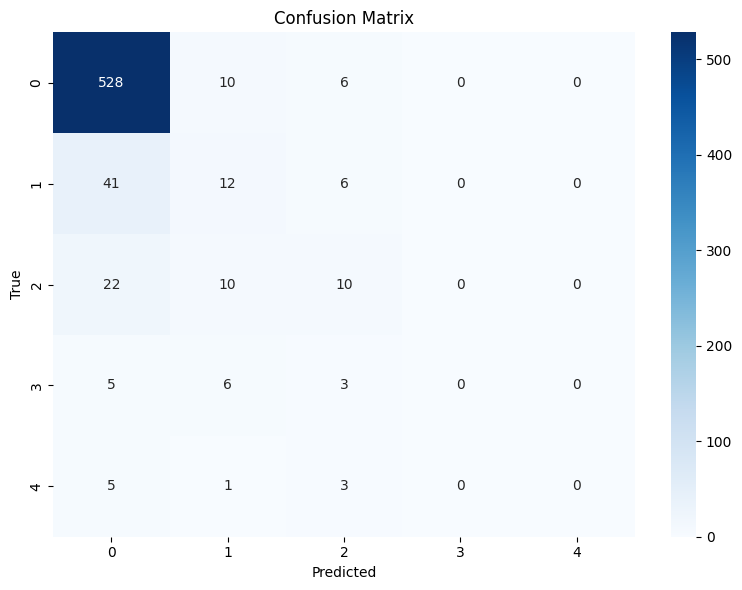


Test AUC (macro-average, OVR): 0.7628


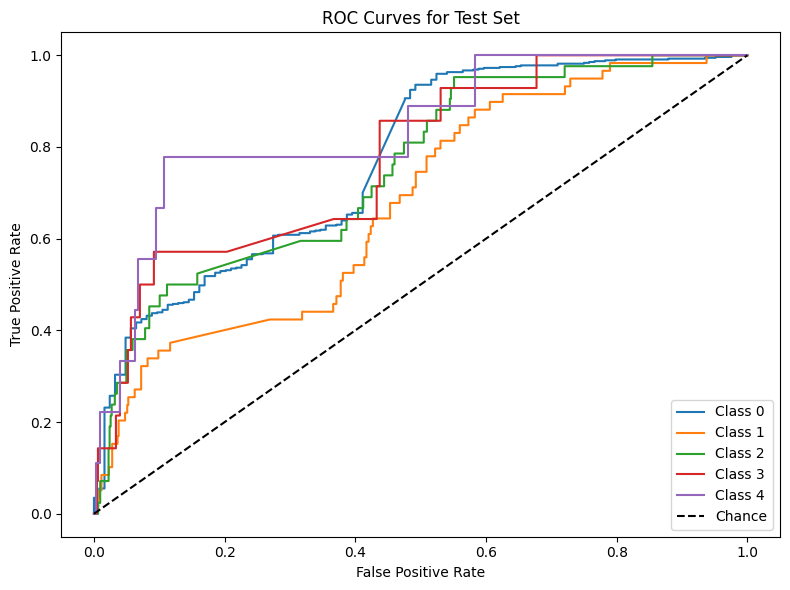

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       455
           1       0.50      0.19      0.28        52
           2       0.29      0.34      0.31        29
           3       1.00      0.10      0.18        10
           4       0.00      0.00      0.00         8

    accuracy                           0.84       554
   macro avg       0.53      0.32      0.34       554
weighted avg       0.81      0.84      0.81       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


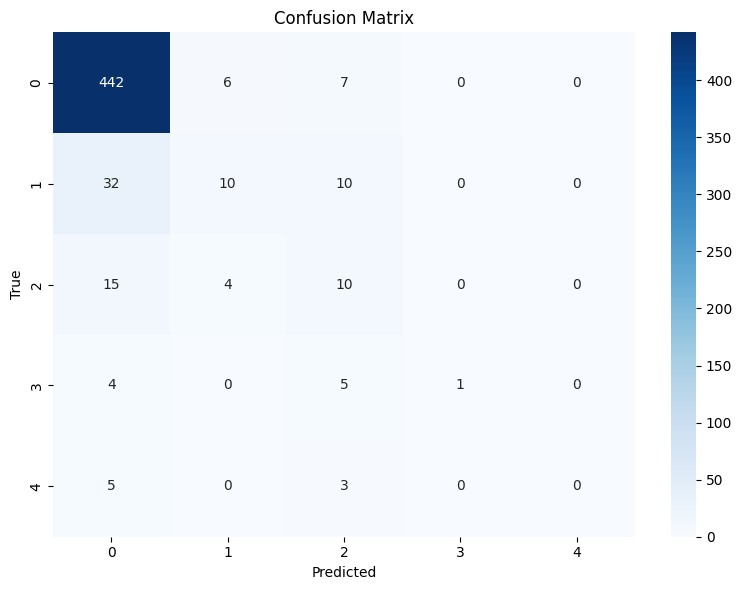


Test AUC (macro-average, OVR): 0.7513


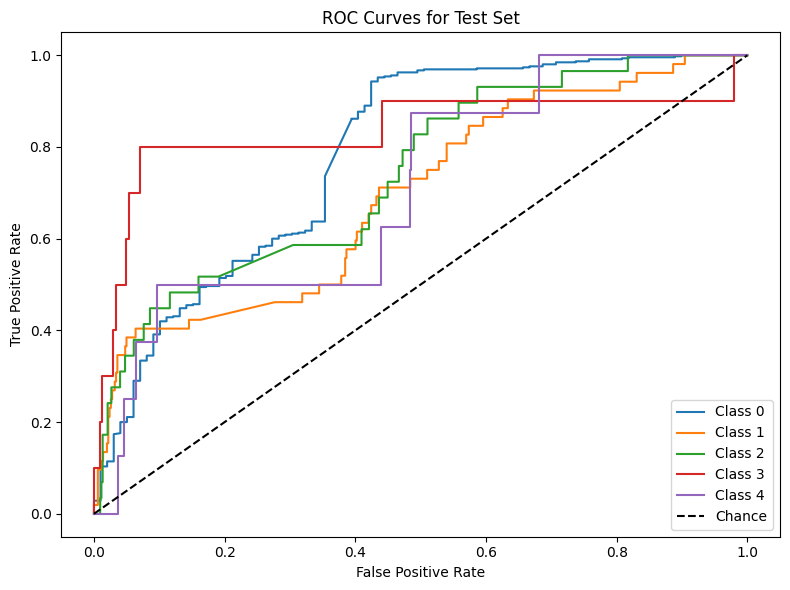

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       395
           1       0.36      0.50      0.42        40
           2       0.22      0.21      0.21        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       477
   macro avg       0.30      0.33      0.31       477
weighted avg       0.80      0.82      0.81       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


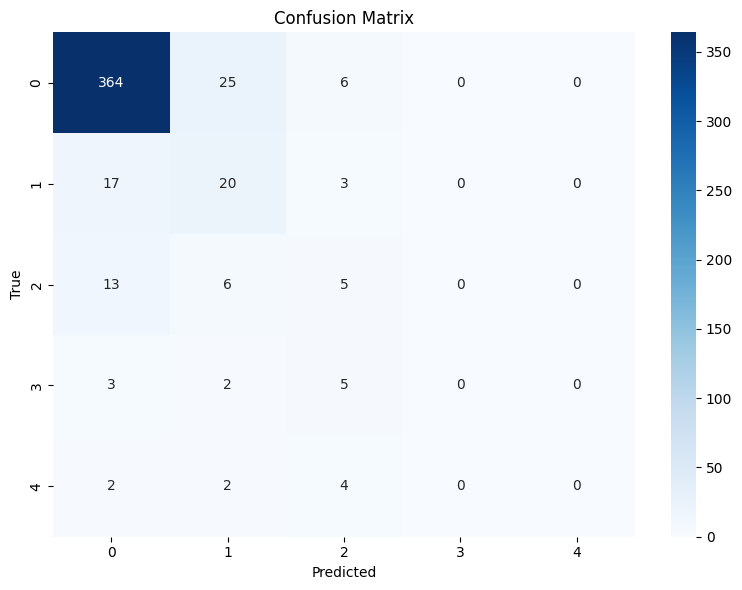


Test AUC (macro-average, OVR): 0.7717


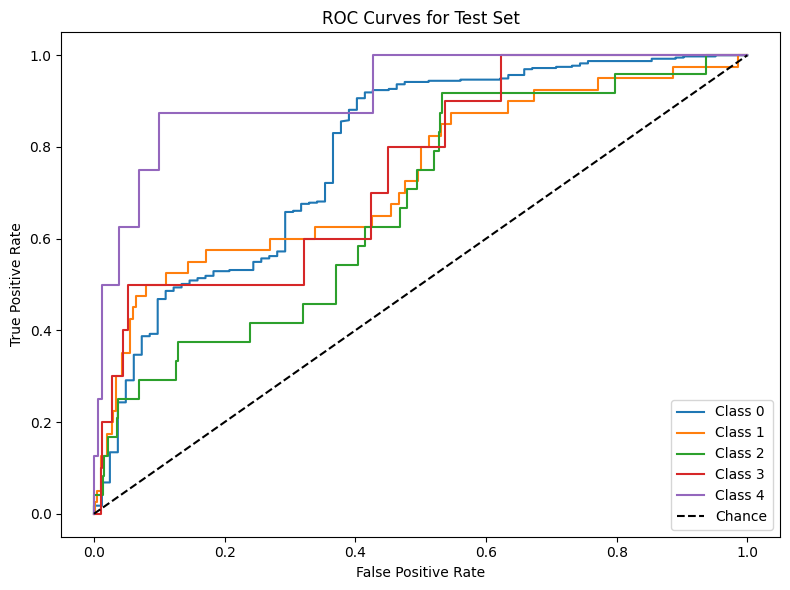

In [7]:
# temp = "sample"  # hoặc "no_sample" tùy thuộc cách bạn lưu model trước đó

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Đường dẫn đúng cho model Keras (.h5)
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.h5'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # Trích xuất mapping trường học
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Dự đoán trên tập test
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Add SMOTE Sample


=== Training Phase 1 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 18s - 18ms/step - accuracy: 0.5326 - loss: 1.0608 - val_accuracy: 0.4552 - val_loss: 1.1302
Epoch 2/30
987/987 - 7s - 7ms/step - accuracy: 0.6077 - loss: 0.9287 - val_accuracy: 0.4766 - val_loss: 1.1481
Epoch 3/30
987/987 - 7s - 7ms/step - accuracy: 0.6340 - loss: 0.8849 - val_accuracy: 0.5801 - val_loss: 1.0158
Epoch 4/30
987/987 - 7s - 7ms/step - accuracy: 0.6486 - loss: 0.8560 - val_accuracy: 0.5915 - val_loss: 1.0194
Epoch 5/30
987/987 - 6s - 6ms/step - accuracy: 0.6591 - loss: 0.8378 - val_accuracy: 0.6000 - val_loss: 0.9718
Epoch 6/30
987/987 - 6s - 7ms/step - accuracy: 0.6622 - loss: 0.8235 - val_accuracy: 0.6052 - val_loss: 0.9842
Epoch 7/30
987/987 - 6s - 6ms/step - accuracy: 0.6676 - loss: 0.8098 - val_accuracy: 0.6269 - val_loss: 0.9584
Epoch 8/30
987/987 - 6s - 6ms/step - accuracy: 0.6714 - loss: 0.8031 - val_accuracy: 0.6177 - val_loss: 0.9508
Epoch 9/30
987/987 - 6s - 6ms/step - accuracy: 0.6736 - loss: 0.7952 - val_accuracy: 0.6018 - val_loss: 0.9728
Epoch 10/3

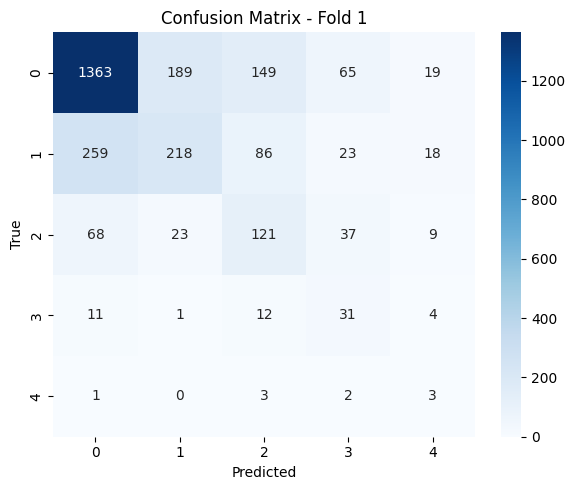

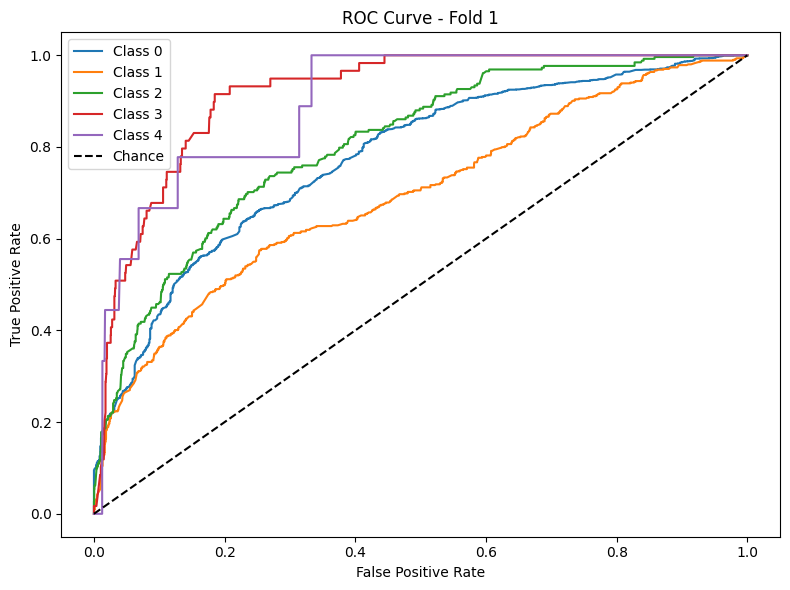

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 21s - 22ms/step - accuracy: 0.5243 - loss: 1.0621 - val_accuracy: 0.4359 - val_loss: 1.1168
Epoch 2/30
987/987 - 7s - 7ms/step - accuracy: 0.6044 - loss: 0.9136 - val_accuracy: 0.5055 - val_loss: 1.1057
Epoch 3/30
987/987 - 8s - 8ms/step - accuracy: 0.6402 - loss: 0.8662 - val_accuracy: 0.5637 - val_loss: 1.0177
Epoch 4/30
987/987 - 7s - 7ms/step - accuracy: 0.6630 - loss: 0.8328 - val_accuracy: 0.5442 - val_loss: 1.0363
Epoch 5/30
987/987 - 7s - 7ms/step - accuracy: 0.6753 - loss: 0.8153 - val_accuracy: 0.5590 - val_loss: 0.9804
Epoch 6/30
987/987 - 7s - 7ms/step - accuracy: 0.6781 - loss: 0.8039 - val_accuracy: 0.5494 - val_loss: 1.0151
Epoch 7/30
987/987 - 7s - 7ms/step - accuracy: 0.6814 - loss: 0.7885 - val_accuracy: 0.5475 - val_loss: 1.0370
Epoch 8/30
987/987 - 7s - 7ms/step - accuracy: 0.6865 - loss: 0.7864 - val_accuracy: 0.5910 - val_loss: 0.9736
Epoch 9/30
987/987 - 7s - 7ms/step - accuracy: 0.6895 - loss: 0.7742 - val_accuracy: 0.5726 - val_loss: 0.9838
Epoch 10/3

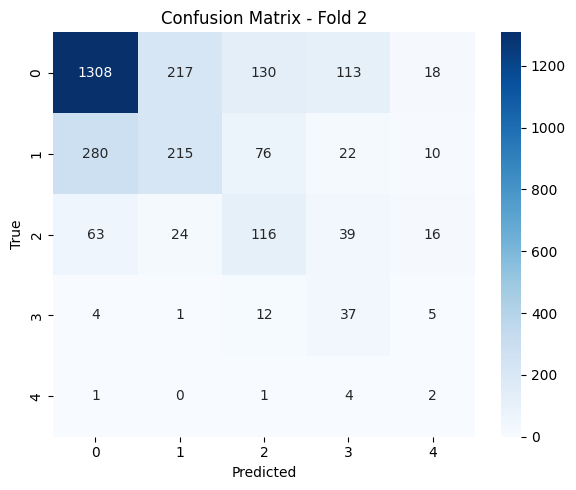

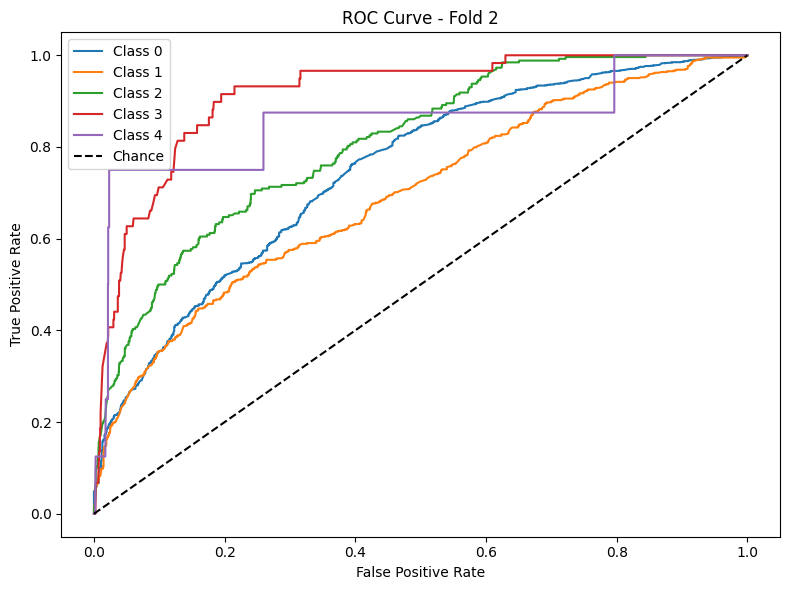

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 18s - 18ms/step - accuracy: 0.5276 - loss: 1.0693 - val_accuracy: 0.4473 - val_loss: 1.1267
Epoch 2/30
987/987 - 7s - 7ms/step - accuracy: 0.6070 - loss: 0.9241 - val_accuracy: 0.4853 - val_loss: 1.1565
Epoch 3/30
987/987 - 7s - 7ms/step - accuracy: 0.6324 - loss: 0.8908 - val_accuracy: 0.5641 - val_loss: 1.0177
Epoch 4/30
987/987 - 7s - 7ms/step - accuracy: 0.6510 - loss: 0.8538 - val_accuracy: 0.6006 - val_loss: 0.9963
Epoch 5/30
987/987 - 7s - 7ms/step - accuracy: 0.6623 - loss: 0.8335 - val_accuracy: 0.5744 - val_loss: 1.0227
Epoch 6/30
987/987 - 7s - 7ms/step - accuracy: 0.6659 - loss: 0.8186 - val_accuracy: 0.5542 - val_loss: 1.0072
Epoch 7/30
987/987 - 7s - 7ms/step - accuracy: 0.6712 - loss: 0.8068 - val_accuracy: 0.5302 - val_loss: 1.0480
Epoch 8/30
987/987 - 7s - 7ms/step - accuracy: 0.6761 - loss: 0.8004 - val_accuracy: 0.5943 - val_loss: 0.9619
Epoch 9/30
987/987 - 7s - 7ms/step - accuracy: 0.6814 - loss: 0.7859 - val_accuracy: 0.5623 - val_loss: 0.9899
Epoch 10/3

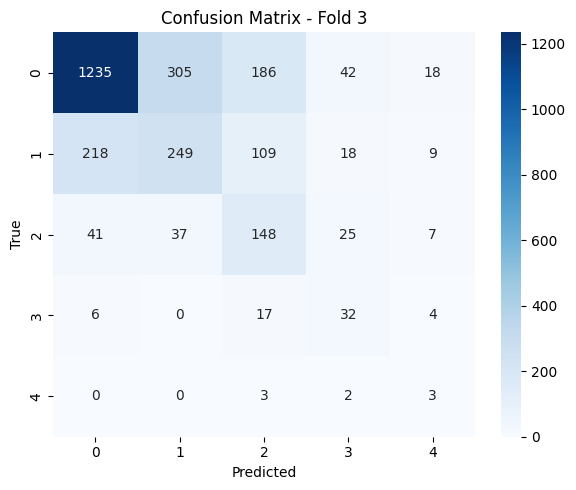

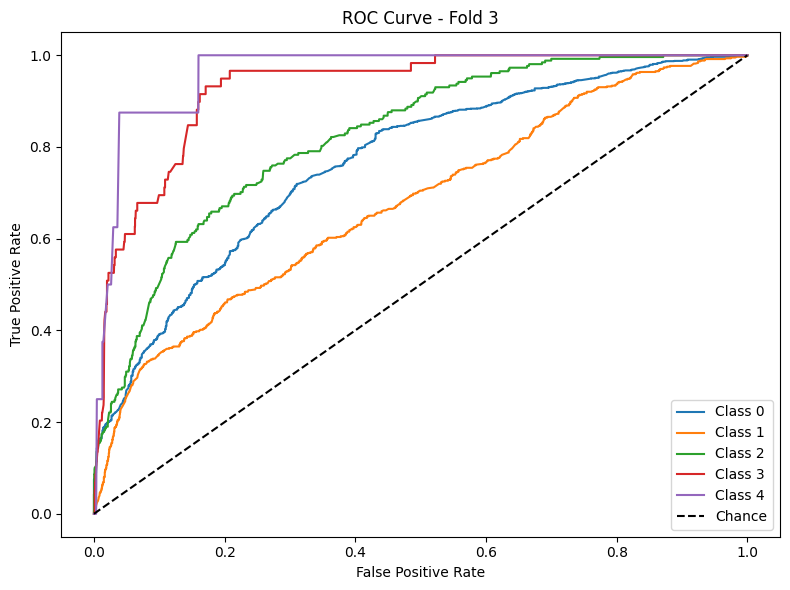

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 19s - 20ms/step - accuracy: 0.5255 - loss: 1.0701 - val_accuracy: 0.2354 - val_loss: 1.1835
Epoch 2/30
987/987 - 6s - 7ms/step - accuracy: 0.5994 - loss: 0.9221 - val_accuracy: 0.4145 - val_loss: 1.1457
Epoch 3/30
987/987 - 6s - 7ms/step - accuracy: 0.6312 - loss: 0.8761 - val_accuracy: 0.5914 - val_loss: 1.0401
Epoch 4/30
987/987 - 6s - 6ms/step - accuracy: 0.6563 - loss: 0.8444 - val_accuracy: 0.6131 - val_loss: 0.9636
Epoch 5/30
987/987 - 6s - 6ms/step - accuracy: 0.6646 - loss: 0.8267 - val_accuracy: 0.5840 - val_loss: 1.0374
Epoch 6/30
987/987 - 6s - 6ms/step - accuracy: 0.6727 - loss: 0.8105 - val_accuracy: 0.5958 - val_loss: 1.0059
Epoch 7/30
987/987 - 6s - 6ms/step - accuracy: 0.6776 - loss: 0.7983 - val_accuracy: 0.6080 - val_loss: 0.9474
Epoch 8/30
987/987 - 6s - 6ms/step - accuracy: 0.6817 - loss: 0.7895 - val_accuracy: 0.6057 - val_loss: 0.9721
Epoch 9/30
987/987 - 6s - 6ms/step - accuracy: 0.6836 - loss: 0.7838 - val_accuracy: 0.6021 - val_loss: 0.9587
Epoch 10/3

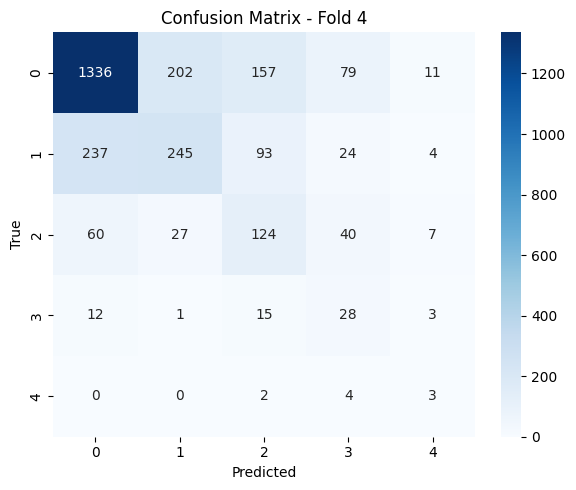

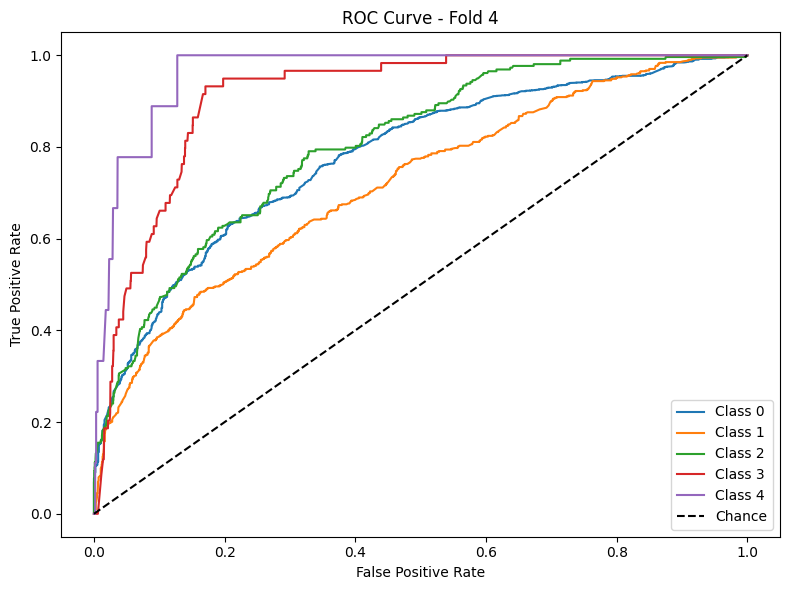

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 16s - 16ms/step - accuracy: 0.5313 - loss: 1.0562 - val_accuracy: 0.5122 - val_loss: 1.1351
Epoch 2/30
987/987 - 6s - 7ms/step - accuracy: 0.6310 - loss: 0.9013 - val_accuracy: 0.5693 - val_loss: 1.0580
Epoch 3/30
987/987 - 6s - 6ms/step - accuracy: 0.6534 - loss: 0.8704 - val_accuracy: 0.5958 - val_loss: 1.0018
Epoch 4/30
987/987 - 6s - 7ms/step - accuracy: 0.6663 - loss: 0.8385 - val_accuracy: 0.5906 - val_loss: 1.0149
Epoch 5/30
987/987 - 7s - 7ms/step - accuracy: 0.6757 - loss: 0.8219 - val_accuracy: 0.6142 - val_loss: 0.9473
Epoch 6/30
987/987 - 7s - 7ms/step - accuracy: 0.6815 - loss: 0.8097 - val_accuracy: 0.5951 - val_loss: 0.9768
Epoch 7/30
987/987 - 7s - 7ms/step - accuracy: 0.6795 - loss: 0.8016 - val_accuracy: 0.5623 - val_loss: 0.9796
Epoch 8/30
987/987 - 6s - 7ms/step - accuracy: 0.6832 - loss: 0.7907 - val_accuracy: 0.6139 - val_loss: 0.9423
Epoch 9/30
987/987 - 6s - 6ms/step - accuracy: 0.6841 - loss: 0.7859 - val_accuracy: 0.6301 - val_loss: 0.9350
Epoch 10/3

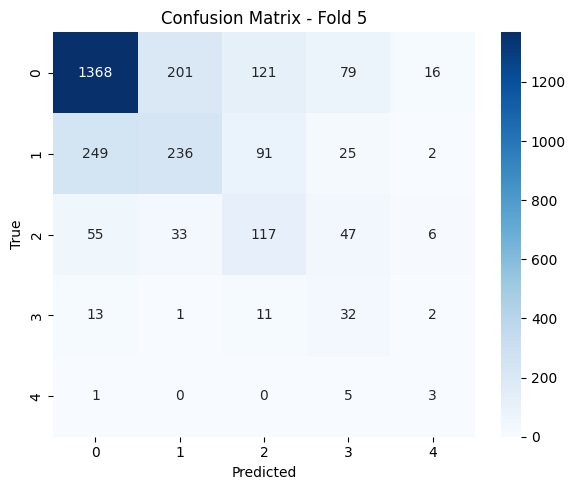

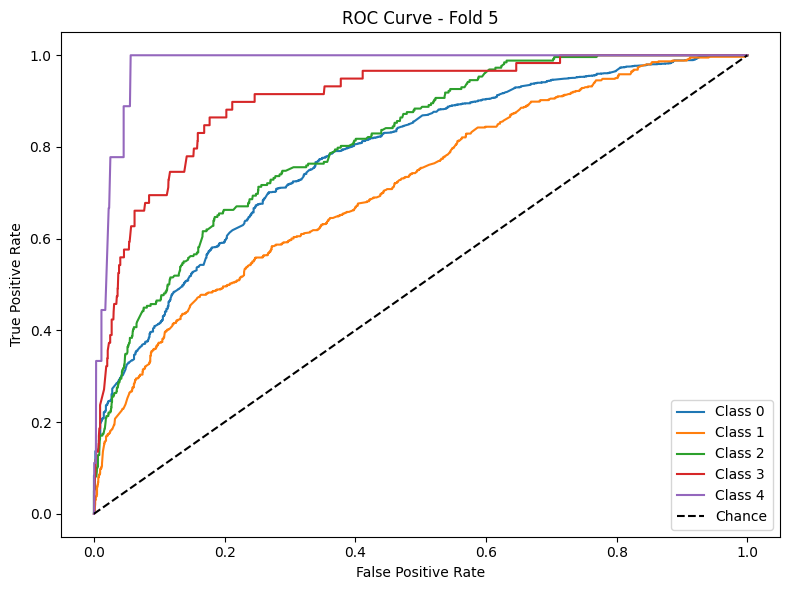


Average Accuracy: 0.6317
Average F1 Macro: 0.3992
Average AUC: 0.8252

=== Training Phase 2 ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
824/824 - 17s - 20ms/step - accuracy: 0.5419 - loss: 1.0471 - val_accuracy: 0.4204 - val_loss: 1.1630
Epoch 2/30
824/824 - 6s - 7ms/step - accuracy: 0.6293 - loss: 0.8921 - val_accuracy: 0.5305 - val_loss: 1.0915
Epoch 3/30
824/824 - 6s - 7ms/step - accuracy: 0.6569 - loss: 0.8442 - val_accuracy: 0.5615 - val_loss: 1.0249
Epoch 4/30
824/824 - 6s - 7ms/step - accuracy: 0.6664 - loss: 0.8167 - val_accuracy: 0.5858 - val_loss: 1.0207
Epoch 5/30
824/824 - 6s - 7ms/step - accuracy: 0.6748 - loss: 0.8005 - val_accuracy: 0.5823 - val_loss: 1.0170
Epoch 6/30
824/824 - 6s - 7ms/step - accuracy: 0.6771 - loss: 0.7879 - val_accuracy: 0.6000 - val_loss: 0.9825
Epoch 7/30
824/824 - 6s - 7ms/step - accuracy: 0.6852 - loss: 0.7720 - val_accuracy: 0.5947 - val_loss: 0.9950
Epoch 8/30
824/824 - 6s - 8ms/step - accuracy: 0.6852 - loss: 0.7677 - val_accuracy: 0.5726 - val_loss: 0.9779
Epoch 9/30
824/824 - 6s - 7ms/step - accuracy: 0.6920 - loss: 0.7553 - val_accuracy: 0.5956 - val_loss: 0.9896

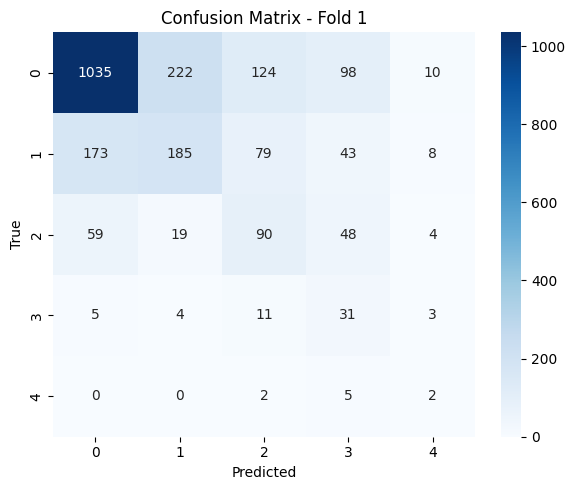

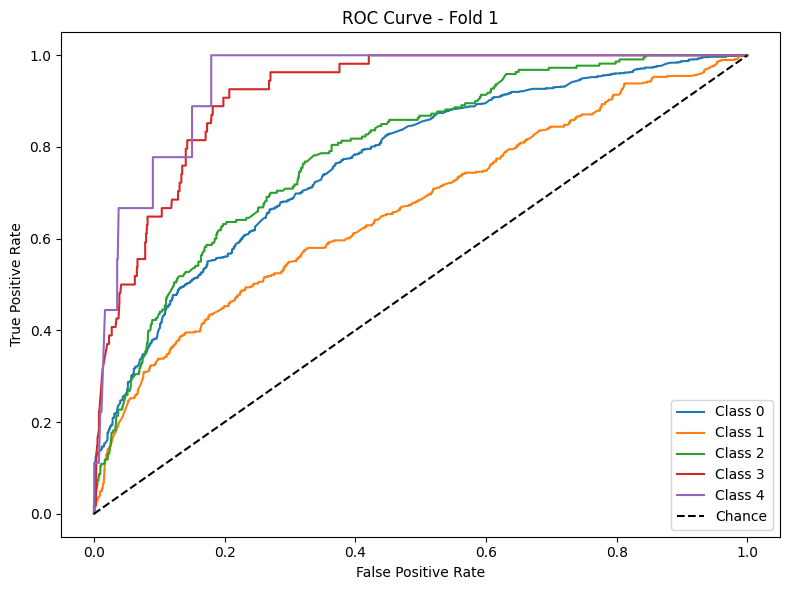

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 20s - 25ms/step - accuracy: 0.5524 - loss: 1.0282 - val_accuracy: 0.5049 - val_loss: 1.1670
Epoch 2/30
824/824 - 6s - 7ms/step - accuracy: 0.6360 - loss: 0.8775 - val_accuracy: 0.5907 - val_loss: 1.0487
Epoch 3/30
824/824 - 6s - 7ms/step - accuracy: 0.6586 - loss: 0.8388 - val_accuracy: 0.5863 - val_loss: 1.0343
Epoch 4/30
824/824 - 6s - 7ms/step - accuracy: 0.6683 - loss: 0.8164 - val_accuracy: 0.6000 - val_loss: 1.0266
Epoch 5/30
824/824 - 6s - 7ms/step - accuracy: 0.6742 - loss: 0.7990 - val_accuracy: 0.5965 - val_loss: 0.9885
Epoch 6/30
824/824 - 6s - 7ms/step - accuracy: 0.6788 - loss: 0.7847 - val_accuracy: 0.5863 - val_loss: 0.9838
Epoch 7/30
824/824 - 6s - 7ms/step - accuracy: 0.6859 - loss: 0.7746 - val_accuracy: 0.5642 - val_loss: 1.0176
Epoch 8/30
824/824 - 6s - 7ms/step - accuracy: 0.6852 - loss: 0.7656 - val_accuracy: 0.6040 - val_loss: 0.9553
Epoch 9/30
824/824 - 6s - 7ms/step - accuracy: 0.6901 - loss: 0.7549 - val_accuracy: 0.6124 - val_loss: 0.9526
Epoch 10/3

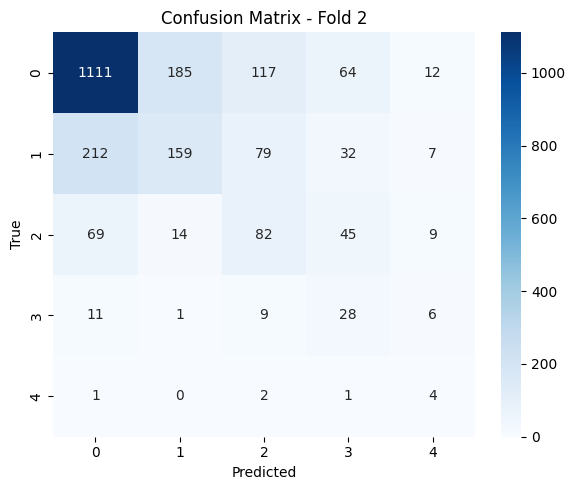

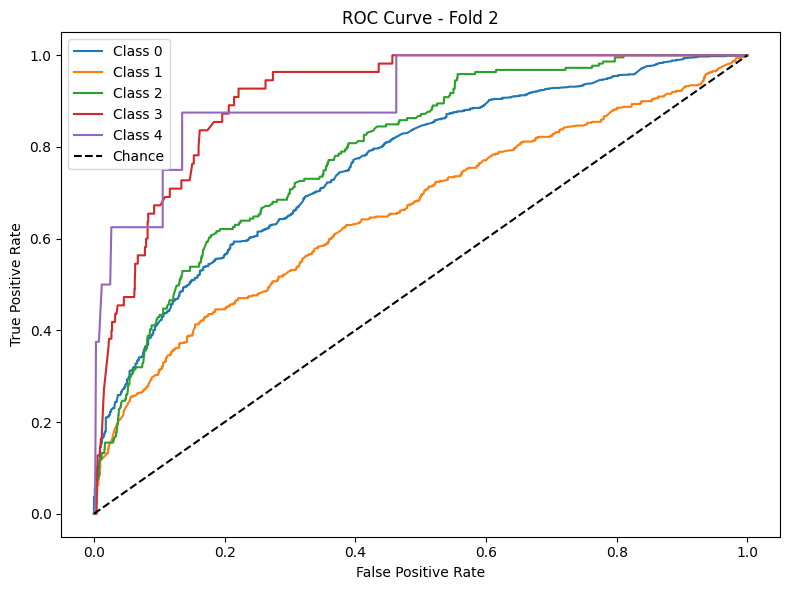

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 17s - 21ms/step - accuracy: 0.5313 - loss: 1.0526 - val_accuracy: 0.3386 - val_loss: 1.2124
Epoch 2/30
824/824 - 6s - 7ms/step - accuracy: 0.6332 - loss: 0.8859 - val_accuracy: 0.4892 - val_loss: 1.1394
Epoch 3/30
824/824 - 6s - 7ms/step - accuracy: 0.6562 - loss: 0.8415 - val_accuracy: 0.5706 - val_loss: 1.0758
Epoch 4/30
824/824 - 6s - 7ms/step - accuracy: 0.6728 - loss: 0.8099 - val_accuracy: 0.6034 - val_loss: 0.9963
Epoch 5/30
824/824 - 6s - 7ms/step - accuracy: 0.6818 - loss: 0.7866 - val_accuracy: 0.5795 - val_loss: 0.9950
Epoch 6/30
824/824 - 6s - 7ms/step - accuracy: 0.6875 - loss: 0.7721 - val_accuracy: 0.5485 - val_loss: 1.0236
Epoch 7/30
824/824 - 6s - 7ms/step - accuracy: 0.6919 - loss: 0.7643 - val_accuracy: 0.5795 - val_loss: 0.9581
Epoch 8/30
824/824 - 6s - 7ms/step - accuracy: 0.6971 - loss: 0.7553 - val_accuracy: 0.5852 - val_loss: 1.0051
Epoch 9/30
824/824 - 6s - 7ms/step - accuracy: 0.7011 - loss: 0.7442 - val_accuracy: 0.5613 - val_loss: 1.0104
Epoch 10/3

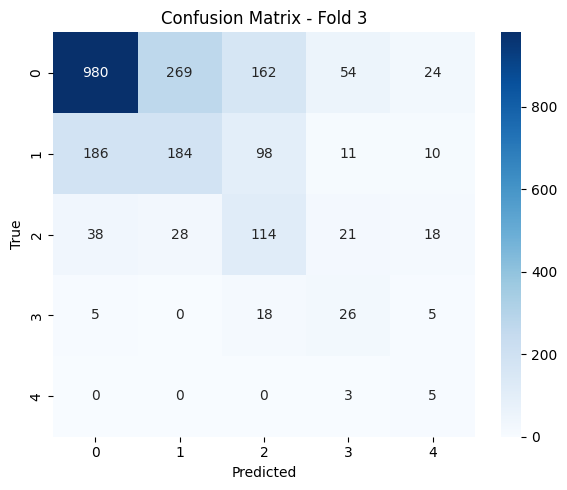

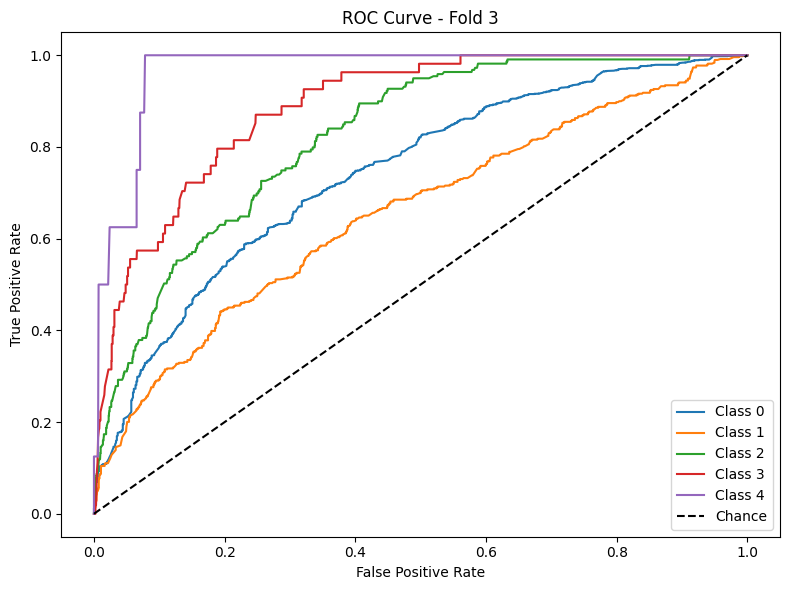

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
824/824 - 20s - 25ms/step - accuracy: 0.5100 - loss: 1.0934 - val_accuracy: 0.3727 - val_loss: 1.1541
Epoch 2/30
824/824 - 6s - 8ms/step - accuracy: 0.5958 - loss: 0.9455 - val_accuracy: 0.5511 - val_loss: 1.0313
Epoch 3/30
824/824 - 6s - 7ms/step - accuracy: 0.6291 - loss: 0.9072 - val_accuracy: 0.5631 - val_loss: 1.0483
Epoch 4/30
824/824 - 6s - 8ms/step - accuracy: 0.6454 - loss: 0.8800 - val_accuracy: 0.5972 - val_loss: 0.9849
Epoch 5/30
824/824 - 6s - 7ms/step - accuracy: 0.6566 - loss: 0.8540 - val_accuracy: 0.5994 - val_loss: 0.9826
Epoch 6/30
824/824 - 6s - 7ms/step - accuracy: 0.6591 - loss: 0.8407 - val_accuracy: 0.6078 - val_loss: 0.9579
Epoch 7/30
824/824 - 6s - 7ms/step - accuracy: 0.6630 - loss: 0.8289 - val_accuracy: 0.5737 - val_loss: 0.9667
Epoch 8/30
824/824 - 6s - 7ms/step - accuracy: 0.6693 - loss: 0.8152 - val_accuracy: 0.5613 - val_loss: 0.9851
Epoch 9/30
824/824 - 6s - 7ms/step - accuracy: 0.6738 - loss: 0.8075 - val_accuracy: 0.5834 - val_loss: 0.9583

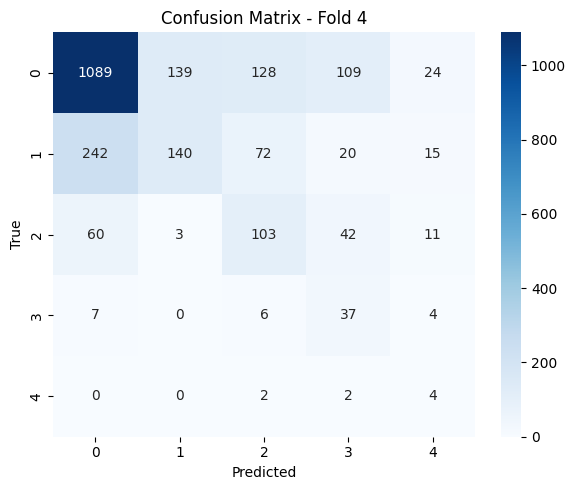

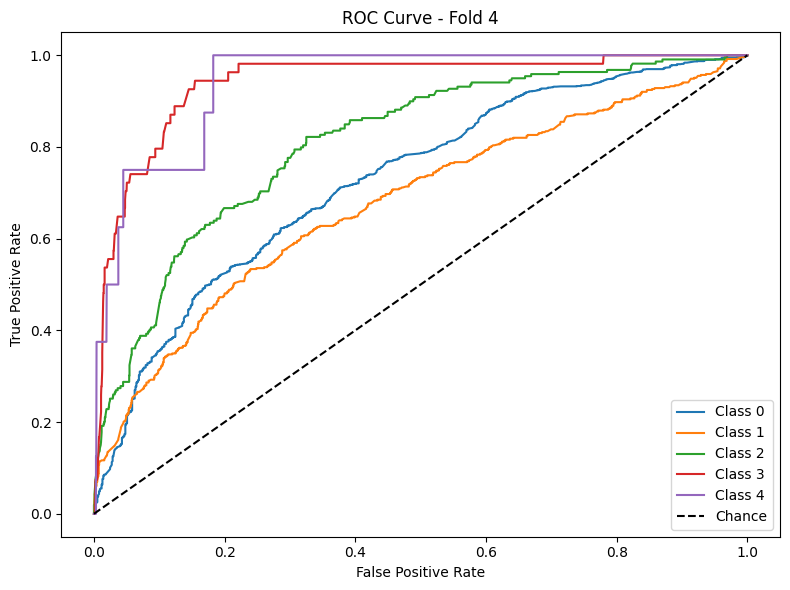

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
824/824 - 17s - 21ms/step - accuracy: 0.5340 - loss: 1.0648 - val_accuracy: 0.4325 - val_loss: 1.1557
Epoch 2/30
824/824 - 6s - 7ms/step - accuracy: 0.6245 - loss: 0.9109 - val_accuracy: 0.5308 - val_loss: 1.1208
Epoch 3/30
824/824 - 6s - 7ms/step - accuracy: 0.6523 - loss: 0.8643 - val_accuracy: 0.5409 - val_loss: 1.1112
Epoch 4/30
824/824 - 6s - 7ms/step - accuracy: 0.6639 - loss: 0.8428 - val_accuracy: 0.5914 - val_loss: 1.0572
Epoch 5/30
824/824 - 6s - 7ms/step - accuracy: 0.6751 - loss: 0.8174 - val_accuracy: 0.5994 - val_loss: 1.0281
Epoch 6/30
824/824 - 6s - 7ms/step - accuracy: 0.6803 - loss: 0.8068 - val_accuracy: 0.5803 - val_loss: 1.0122
Epoch 7/30
824/824 - 6s - 7ms/step - accuracy: 0.6856 - loss: 0.7899 - val_accuracy: 0.6020 - val_loss: 0.9851
Epoch 8/30
824/824 - 6s - 7ms/step - accuracy: 0.6885 - loss: 0.7818 - val_accuracy: 0.6056 - val_loss: 0.9566
Epoch 9/30
824/824 - 6s - 7ms/step - accuracy: 0.6947 - loss: 0.7706 - val_accuracy: 0.5817 - val_loss: 0.9986

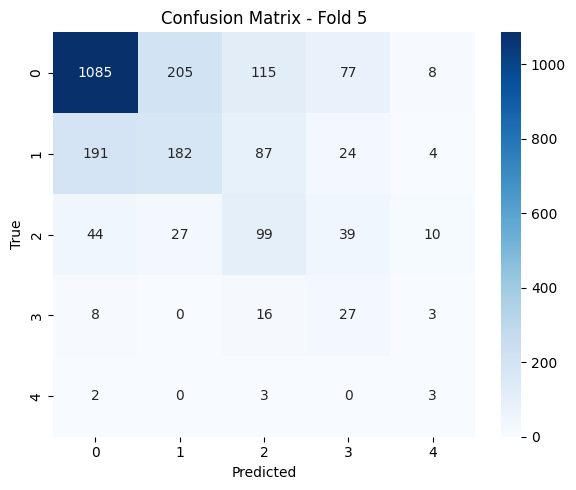

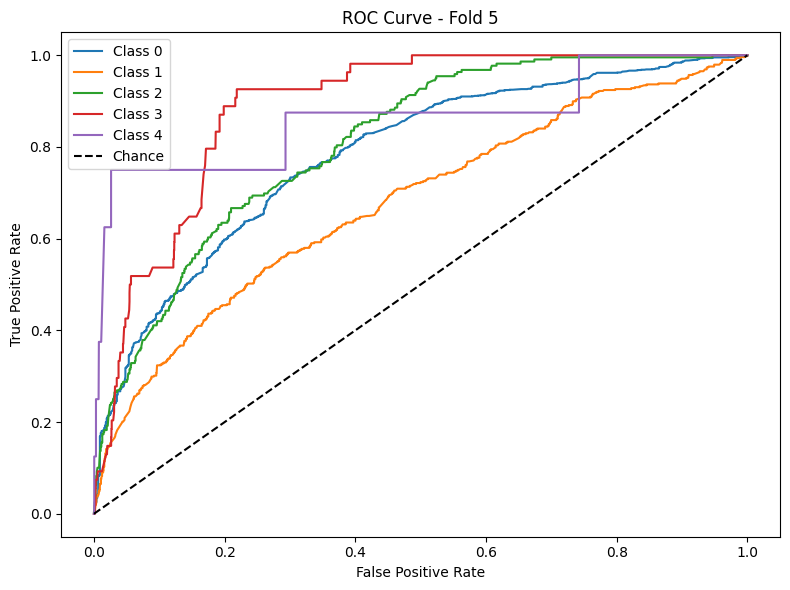


Average Accuracy: 0.6024
Average F1 Macro: 0.3802
Average AUC: 0.8122

=== Training Phase 3 ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
752/752 - 17s - 22ms/step - accuracy: 0.5291 - loss: 1.0534 - val_accuracy: 0.2985 - val_loss: 1.1999
Epoch 2/30
752/752 - 6s - 8ms/step - accuracy: 0.6276 - loss: 0.8766 - val_accuracy: 0.5087 - val_loss: 1.0918
Epoch 3/30
752/752 - 6s - 8ms/step - accuracy: 0.6610 - loss: 0.8310 - val_accuracy: 0.5892 - val_loss: 1.0500
Epoch 4/30
752/752 - 7s - 10ms/step - accuracy: 0.6792 - loss: 0.8053 - val_accuracy: 0.5916 - val_loss: 1.0691
Epoch 5/30
752/752 - 6s - 8ms/step - accuracy: 0.6854 - loss: 0.7893 - val_accuracy: 0.6162 - val_loss: 1.0012
Epoch 6/30
752/752 - 6s - 8ms/step - accuracy: 0.6893 - loss: 0.7736 - val_accuracy: 0.6186 - val_loss: 1.0030
Epoch 7/30
752/752 - 5s - 7ms/step - accuracy: 0.6943 - loss: 0.7683 - val_accuracy: 0.6283 - val_loss: 0.9998
Epoch 8/30
752/752 - 6s - 8ms/step - accuracy: 0.6957 - loss: 0.7607 - val_accuracy: 0.6210 - val_loss: 0.9939
Epoch 9/30
752/752 - 6s - 8ms/step - accuracy: 0.7036 - loss: 0.7492 - val_accuracy: 0.6186 - val_loss: 0.975

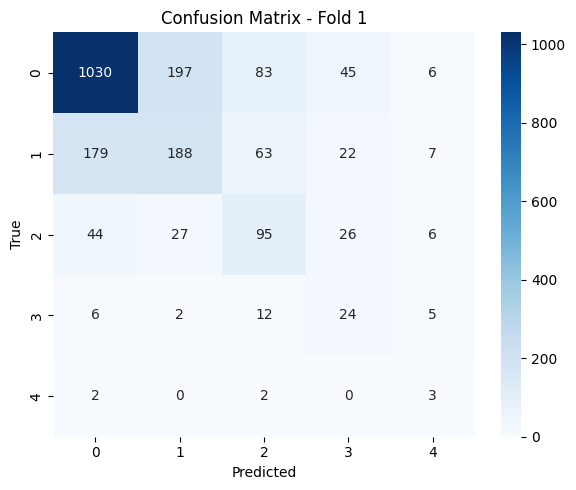

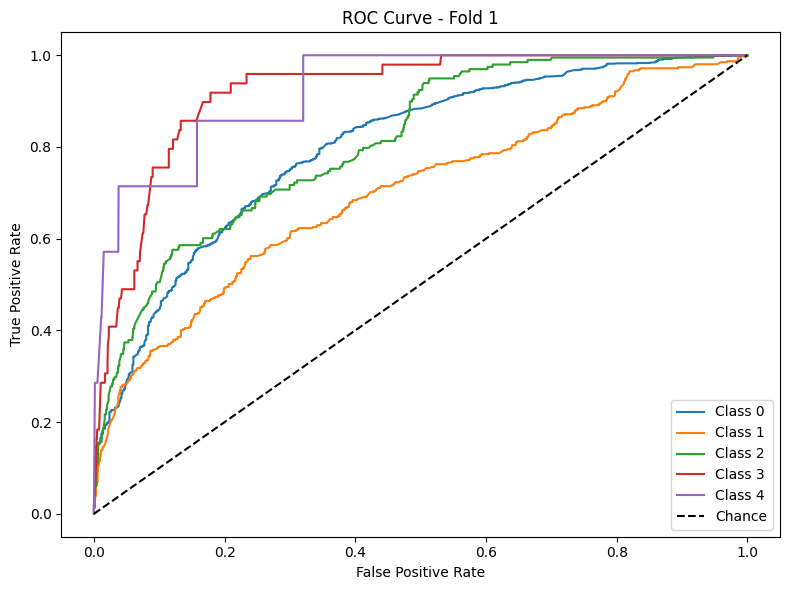

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 21s - 28ms/step - accuracy: 0.5096 - loss: 1.0728 - val_accuracy: 0.3149 - val_loss: 1.1649
Epoch 2/30
752/752 - 7s - 9ms/step - accuracy: 0.6179 - loss: 0.8972 - val_accuracy: 0.5497 - val_loss: 1.0786
Epoch 3/30
752/752 - 6s - 8ms/step - accuracy: 0.6476 - loss: 0.8563 - val_accuracy: 0.5916 - val_loss: 1.0257
Epoch 4/30
752/752 - 7s - 9ms/step - accuracy: 0.6653 - loss: 0.8250 - val_accuracy: 0.5738 - val_loss: 1.0030
Epoch 5/30
752/752 - 7s - 9ms/step - accuracy: 0.6809 - loss: 0.8039 - val_accuracy: 0.6138 - val_loss: 0.9672
Epoch 6/30
752/752 - 6s - 8ms/step - accuracy: 0.6876 - loss: 0.7881 - val_accuracy: 0.5661 - val_loss: 1.0038
Epoch 7/30
752/752 - 7s - 10ms/step - accuracy: 0.6897 - loss: 0.7785 - val_accuracy: 0.5762 - val_loss: 1.0012
Epoch 8/30
752/752 - 6s - 9ms/step - accuracy: 0.6938 - loss: 0.7682 - val_accuracy: 0.5646 - val_loss: 0.9981
Epoch 9/30
752/752 - 6s - 8ms/step - accuracy: 0.7003 - loss: 0.7554 - val_accuracy: 0.5824 - val_loss: 0.9505
Epoch 10/

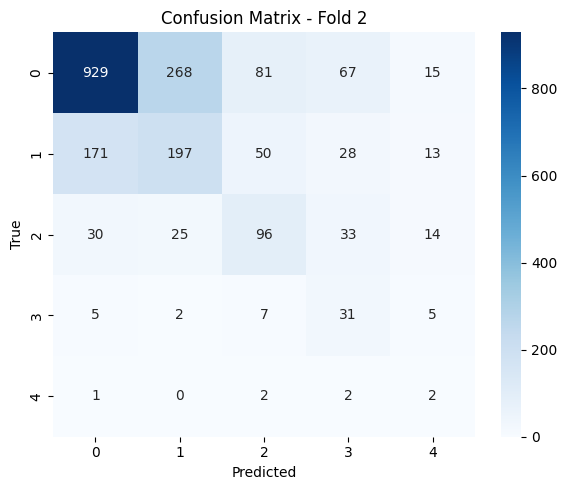

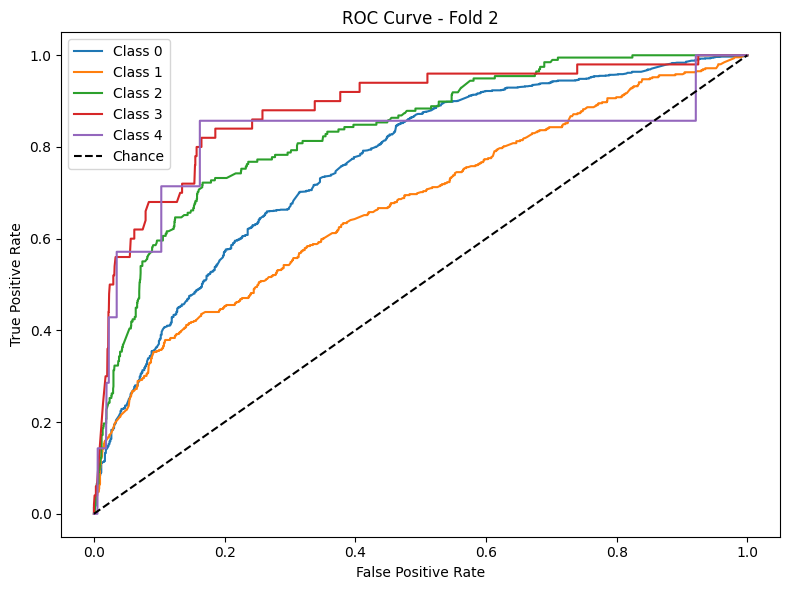

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
752/752 - 19s - 25ms/step - accuracy: 0.5356 - loss: 1.0633 - val_accuracy: 0.4441 - val_loss: 1.1643
Epoch 2/30
752/752 - 7s - 9ms/step - accuracy: 0.6325 - loss: 0.8946 - val_accuracy: 0.5743 - val_loss: 1.0702
Epoch 3/30
752/752 - 8s - 10ms/step - accuracy: 0.6639 - loss: 0.8473 - val_accuracy: 0.5849 - val_loss: 1.0620
Epoch 4/30
752/752 - 7s - 9ms/step - accuracy: 0.6754 - loss: 0.8206 - val_accuracy: 0.5564 - val_loss: 1.0488
Epoch 5/30
752/752 - 6s - 8ms/step - accuracy: 0.6840 - loss: 0.8049 - val_accuracy: 0.5878 - val_loss: 1.0406
Epoch 6/30
752/752 - 6s - 8ms/step - accuracy: 0.6883 - loss: 0.7877 - val_accuracy: 0.5579 - val_loss: 1.0600
Epoch 7/30
752/752 - 7s - 9ms/step - accuracy: 0.6913 - loss: 0.7803 - val_accuracy: 0.5149 - val_loss: 1.0500
Epoch 8/30
752/752 - 6s - 8ms/step - accuracy: 0.6966 - loss: 0.7705 - val_accuracy: 0.5217 - val_loss: 1.0280
Epoch 9/30
752/752 - 7s - 9ms/step - accuracy: 0.6990 - loss: 0.7613 - val_accuracy: 0.5058 - val_loss: 1.067

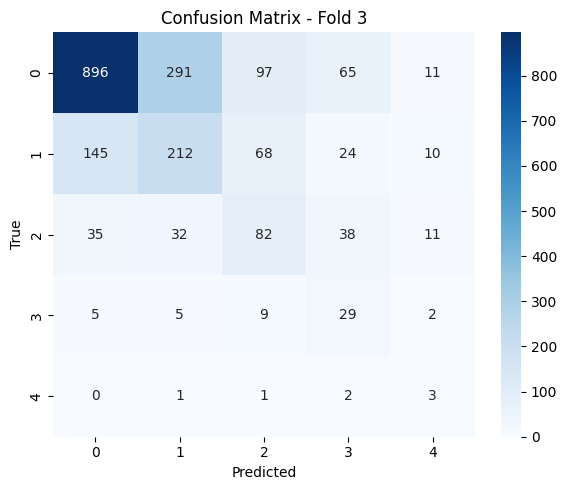

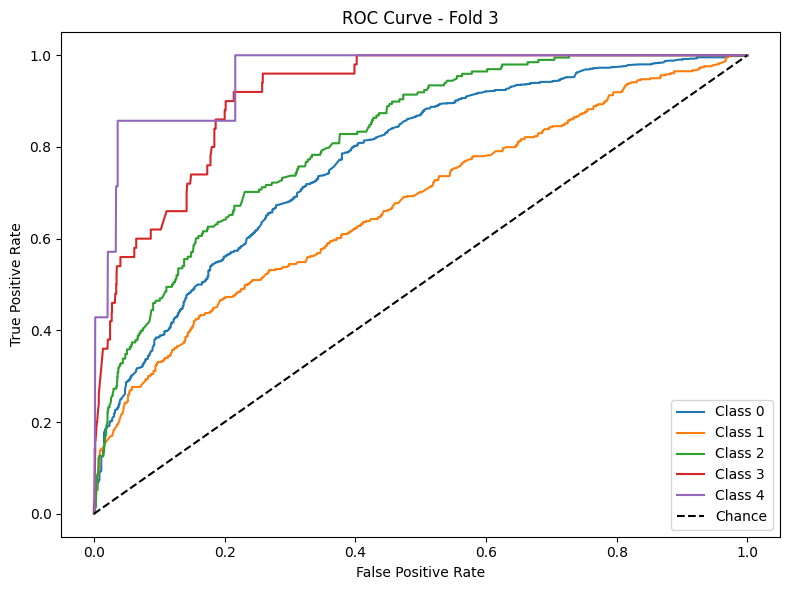

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
752/752 - 19s - 25ms/step - accuracy: 0.5599 - loss: 1.0495 - val_accuracy: 0.5256 - val_loss: 1.0785
Epoch 2/30
752/752 - 7s - 9ms/step - accuracy: 0.6572 - loss: 0.8862 - val_accuracy: 0.5294 - val_loss: 1.0859
Epoch 3/30
752/752 - 6s - 8ms/step - accuracy: 0.6741 - loss: 0.8433 - val_accuracy: 0.5675 - val_loss: 1.0212
Epoch 4/30
752/752 - 7s - 9ms/step - accuracy: 0.6862 - loss: 0.8145 - val_accuracy: 0.5878 - val_loss: 0.9703
Epoch 5/30
752/752 - 7s - 9ms/step - accuracy: 0.6934 - loss: 0.7997 - val_accuracy: 0.5583 - val_loss: 0.9810
Epoch 6/30
752/752 - 7s - 10ms/step - accuracy: 0.6950 - loss: 0.7825 - val_accuracy: 0.5564 - val_loss: 0.9699
Epoch 7/30
752/752 - 6s - 9ms/step - accuracy: 0.7005 - loss: 0.7684 - val_accuracy: 0.5800 - val_loss: 0.9667
Epoch 8/30
752/752 - 7s - 9ms/step - accuracy: 0.7032 - loss: 0.7575 - val_accuracy: 0.5371 - val_loss: 0.9933
Epoch 9/30
752/752 - 6s - 9ms/step - accuracy: 0.7066 - loss: 0.7486 - val_accuracy: 0.5897 - val_loss: 0.937

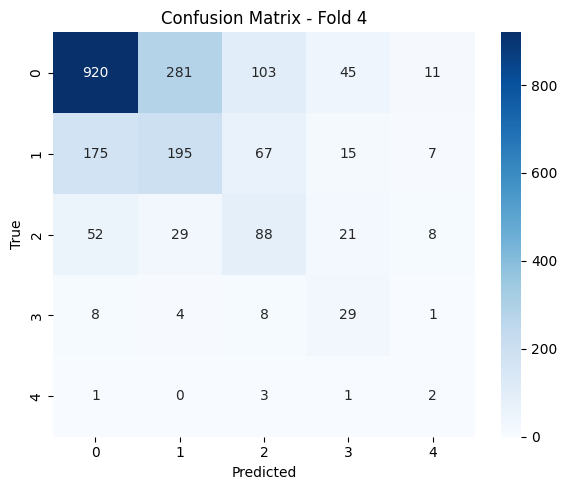

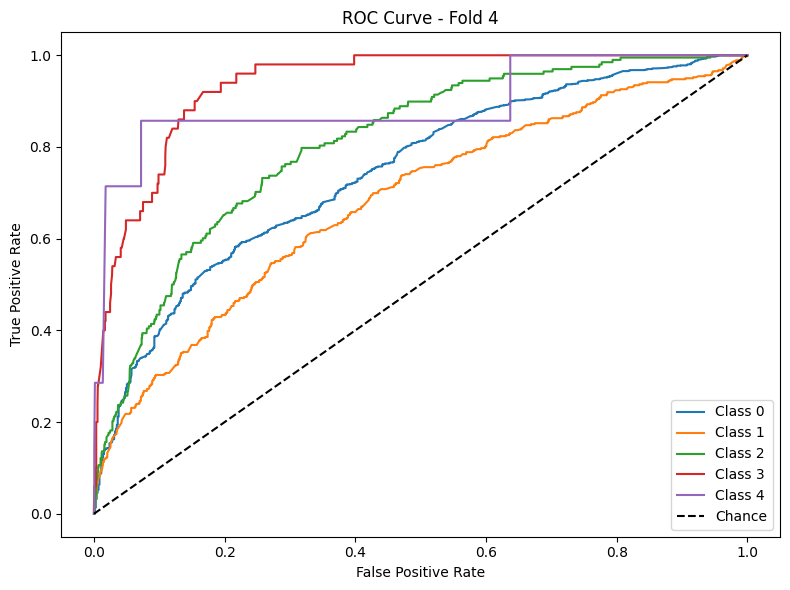

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
752/752 - 24s - 32ms/step - accuracy: 0.5465 - loss: 1.0385 - val_accuracy: 0.4959 - val_loss: 1.1220
Epoch 2/30
752/752 - 9s - 11ms/step - accuracy: 0.6493 - loss: 0.8744 - val_accuracy: 0.5731 - val_loss: 1.0887
Epoch 3/30
752/752 - 6s - 8ms/step - accuracy: 0.6760 - loss: 0.8278 - val_accuracy: 0.5601 - val_loss: 1.0882
Epoch 4/30
752/752 - 6s - 9ms/step - accuracy: 0.6842 - loss: 0.8026 - val_accuracy: 0.5837 - val_loss: 1.0392
Epoch 5/30
752/752 - 6s - 8ms/step - accuracy: 0.6894 - loss: 0.7837 - val_accuracy: 0.6136 - val_loss: 1.0310
Epoch 6/30
752/752 - 7s - 9ms/step - accuracy: 0.6970 - loss: 0.7661 - val_accuracy: 0.6044 - val_loss: 1.0340
Epoch 7/30
752/752 - 7s - 9ms/step - accuracy: 0.7012 - loss: 0.7562 - val_accuracy: 0.6035 - val_loss: 1.0153
Epoch 8/30
752/752 - 7s - 9ms/step - accuracy: 0.7047 - loss: 0.7455 - val_accuracy: 0.6122 - val_loss: 0.9914
Epoch 9/30
752/752 - 7s - 9ms/step - accuracy: 0.7084 - loss: 0.7351 - val_accuracy: 0.5789 - val_loss: 1.023

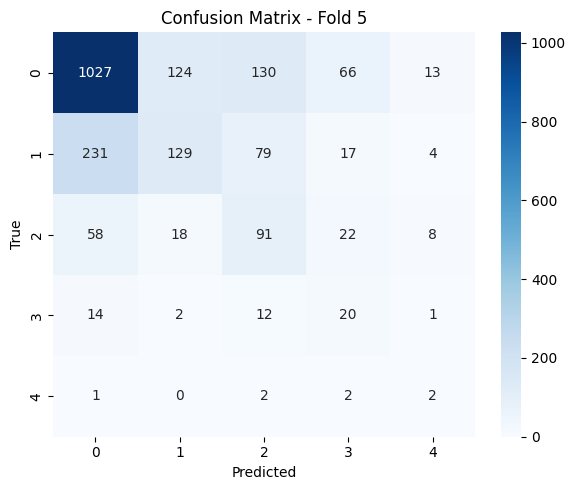

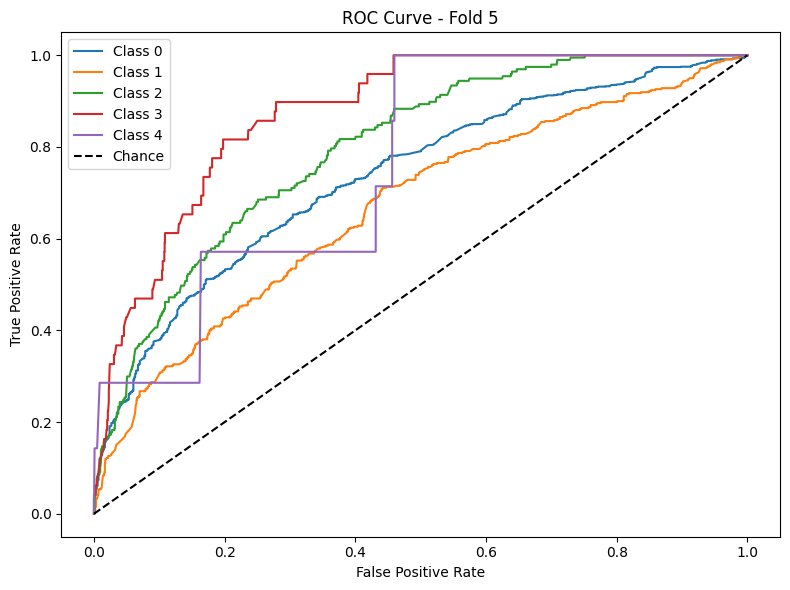


Average Accuracy: 0.6095
Average F1 Macro: 0.3919
Average AUC: 0.8063

=== Training Phase 4 ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
553/553 - 16s - 29ms/step - accuracy: 0.5391 - loss: 1.0632 - val_accuracy: 0.4178 - val_loss: 1.1713
Epoch 2/30
553/553 - 4s - 8ms/step - accuracy: 0.6429 - loss: 0.8589 - val_accuracy: 0.4711 - val_loss: 1.1580
Epoch 3/30
553/553 - 5s - 8ms/step - accuracy: 0.6705 - loss: 0.8227 - val_accuracy: 0.5822 - val_loss: 1.0935
Epoch 4/30
553/553 - 5s - 9ms/step - accuracy: 0.6939 - loss: 0.7914 - val_accuracy: 0.5783 - val_loss: 1.0853
Epoch 5/30
553/553 - 5s - 9ms/step - accuracy: 0.7112 - loss: 0.7670 - val_accuracy: 0.5958 - val_loss: 1.0345
Epoch 6/30
553/553 - 4s - 8ms/step - accuracy: 0.7183 - loss: 0.7464 - val_accuracy: 0.5854 - val_loss: 1.0859
Epoch 7/30
553/553 - 4s - 8ms/step - accuracy: 0.7237 - loss: 0.7361 - val_accuracy: 0.6017 - val_loss: 1.0255
Epoch 8/30
553/553 - 4s - 8ms/step - accuracy: 0.7275 - loss: 0.7199 - val_accuracy: 0.5874 - val_loss: 1.0297
Epoch 9/30
553/553 - 5s - 9ms/step - accuracy: 0.7329 - loss: 0.7063 - val_accuracy: 0.5932 - val_loss: 0.9902

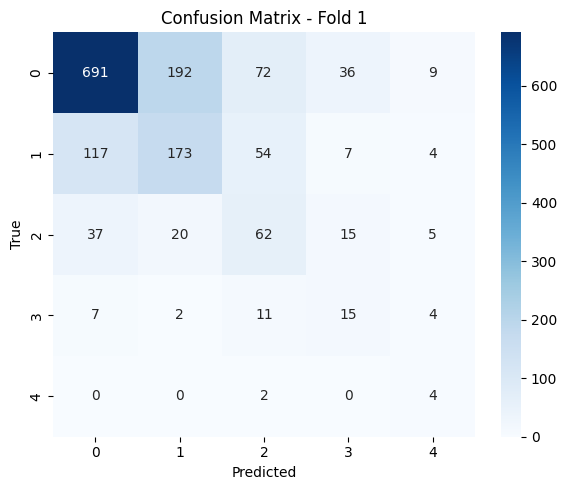

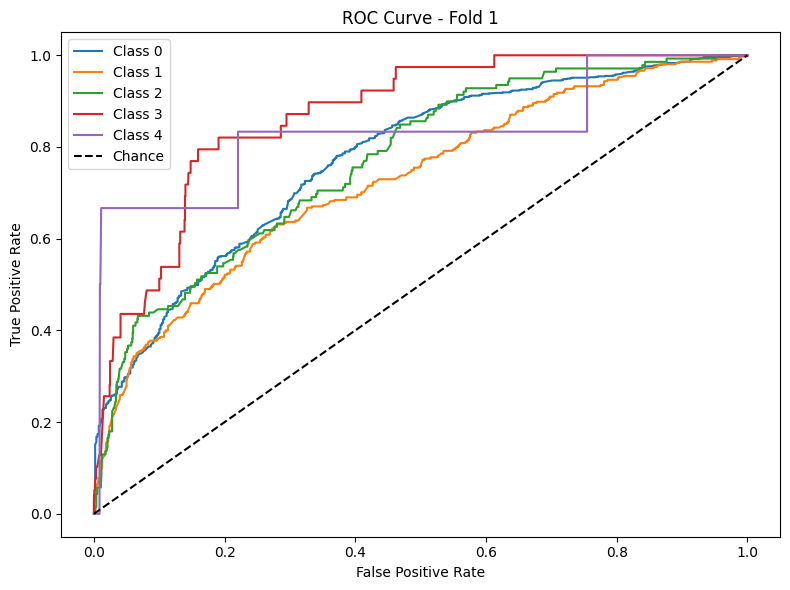

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
553/553 - 16s - 29ms/step - accuracy: 0.5427 - loss: 1.0567 - val_accuracy: 0.4821 - val_loss: 1.1594
Epoch 2/30
553/553 - 5s - 8ms/step - accuracy: 0.6564 - loss: 0.8561 - val_accuracy: 0.5068 - val_loss: 1.1372
Epoch 3/30
553/553 - 4s - 8ms/step - accuracy: 0.6905 - loss: 0.8089 - val_accuracy: 0.5835 - val_loss: 1.1025
Epoch 4/30
553/553 - 4s - 8ms/step - accuracy: 0.7082 - loss: 0.7786 - val_accuracy: 0.5997 - val_loss: 1.0455
Epoch 5/30
553/553 - 4s - 8ms/step - accuracy: 0.7195 - loss: 0.7539 - val_accuracy: 0.5958 - val_loss: 1.0313
Epoch 6/30
553/553 - 4s - 8ms/step - accuracy: 0.7232 - loss: 0.7386 - val_accuracy: 0.6043 - val_loss: 1.0617
Epoch 7/30
553/553 - 4s - 8ms/step - accuracy: 0.7297 - loss: 0.7194 - val_accuracy: 0.6056 - val_loss: 1.0054
Epoch 8/30
553/553 - 4s - 8ms/step - accuracy: 0.7344 - loss: 0.7131 - val_accuracy: 0.6108 - val_loss: 1.0156
Epoch 9/30
553/553 - 4s - 8ms/step - accuracy: 0.7373 - loss: 0.7028 - val_accuracy: 0.5763 - val_loss: 1.0401

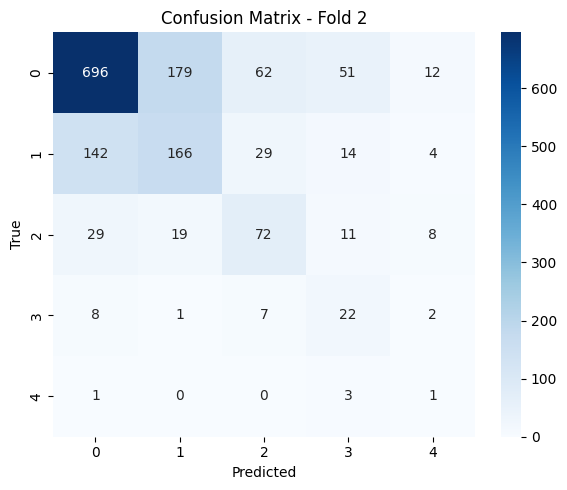

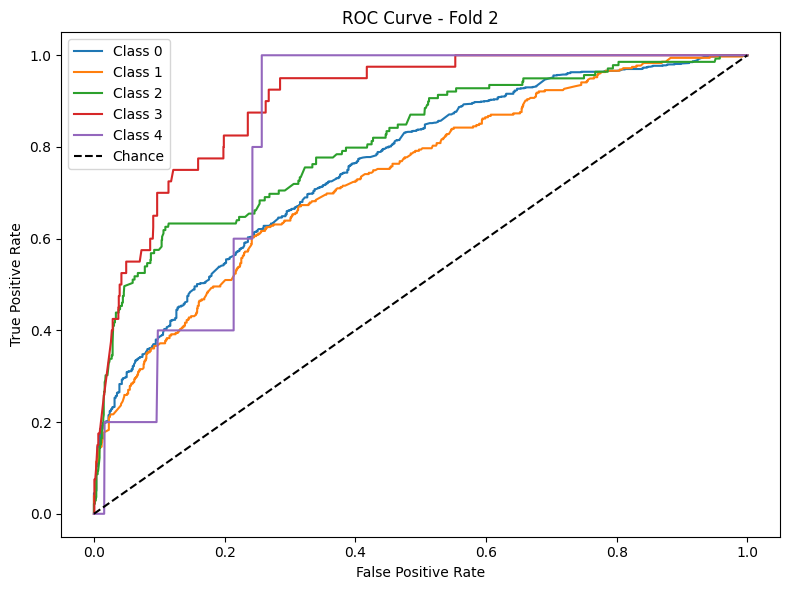

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
553/553 - 20s - 36ms/step - accuracy: 0.5379 - loss: 1.0439 - val_accuracy: 0.4204 - val_loss: 1.1573
Epoch 2/30
553/553 - 4s - 8ms/step - accuracy: 0.6635 - loss: 0.8272 - val_accuracy: 0.5906 - val_loss: 1.0424
Epoch 3/30
553/553 - 4s - 8ms/step - accuracy: 0.6991 - loss: 0.7750 - val_accuracy: 0.5718 - val_loss: 1.0634
Epoch 4/30
553/553 - 4s - 7ms/step - accuracy: 0.7110 - loss: 0.7534 - val_accuracy: 0.5289 - val_loss: 1.0993
Epoch 5/30
553/553 - 4s - 7ms/step - accuracy: 0.7174 - loss: 0.7308 - val_accuracy: 0.5692 - val_loss: 1.0526
Epoch 6/30
553/553 - 4s - 8ms/step - accuracy: 0.7275 - loss: 0.7131 - val_accuracy: 0.6400 - val_loss: 0.9423
Epoch 7/30
553/553 - 4s - 7ms/step - accuracy: 0.7304 - loss: 0.6992 - val_accuracy: 0.6329 - val_loss: 0.9817
Epoch 8/30
553/553 - 4s - 8ms/step - accuracy: 0.7329 - loss: 0.6926 - val_accuracy: 0.6179 - val_loss: 0.9269
Epoch 9/30
553/553 - 4s - 7ms/step - accuracy: 0.7391 - loss: 0.6759 - val_accuracy: 0.6140 - val_loss: 0.9660

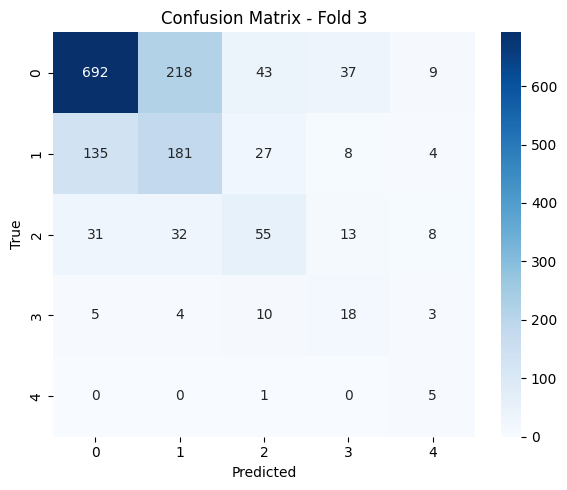

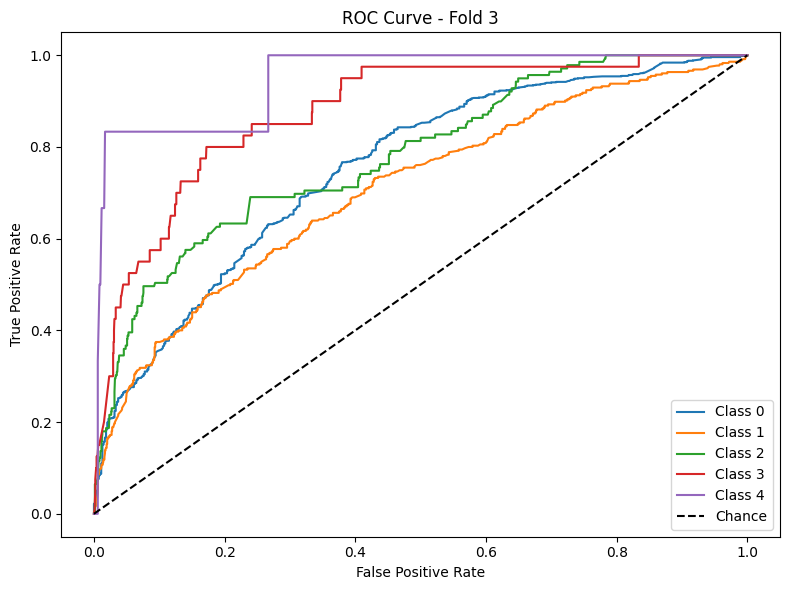

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
553/553 - 15s - 27ms/step - accuracy: 0.5629 - loss: 1.0421 - val_accuracy: 0.4265 - val_loss: 1.1685
Epoch 2/30
553/553 - 4s - 7ms/step - accuracy: 0.6732 - loss: 0.8368 - val_accuracy: 0.5670 - val_loss: 1.0668
Epoch 3/30
553/553 - 4s - 7ms/step - accuracy: 0.6987 - loss: 0.7877 - val_accuracy: 0.6144 - val_loss: 0.9920
Epoch 4/30
553/553 - 4s - 7ms/step - accuracy: 0.7086 - loss: 0.7584 - val_accuracy: 0.5865 - val_loss: 1.0007
Epoch 5/30
553/553 - 4s - 7ms/step - accuracy: 0.7180 - loss: 0.7414 - val_accuracy: 0.6294 - val_loss: 0.9627
Epoch 6/30
553/553 - 4s - 7ms/step - accuracy: 0.7236 - loss: 0.7304 - val_accuracy: 0.6359 - val_loss: 0.9545
Epoch 7/30
553/553 - 4s - 7ms/step - accuracy: 0.7291 - loss: 0.7176 - val_accuracy: 0.6567 - val_loss: 0.9549
Epoch 8/30
553/553 - 4s - 8ms/step - accuracy: 0.7318 - loss: 0.6997 - val_accuracy: 0.6450 - val_loss: 0.9165
Epoch 9/30
553/553 - 4s - 7ms/step - accuracy: 0.7411 - loss: 0.6835 - val_accuracy: 0.6352 - val_loss: 0.9279

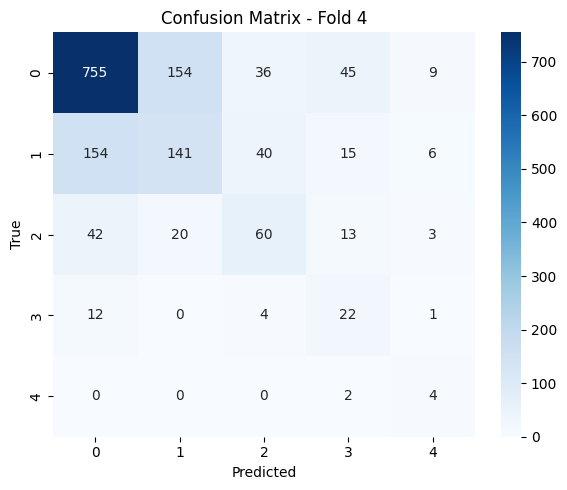

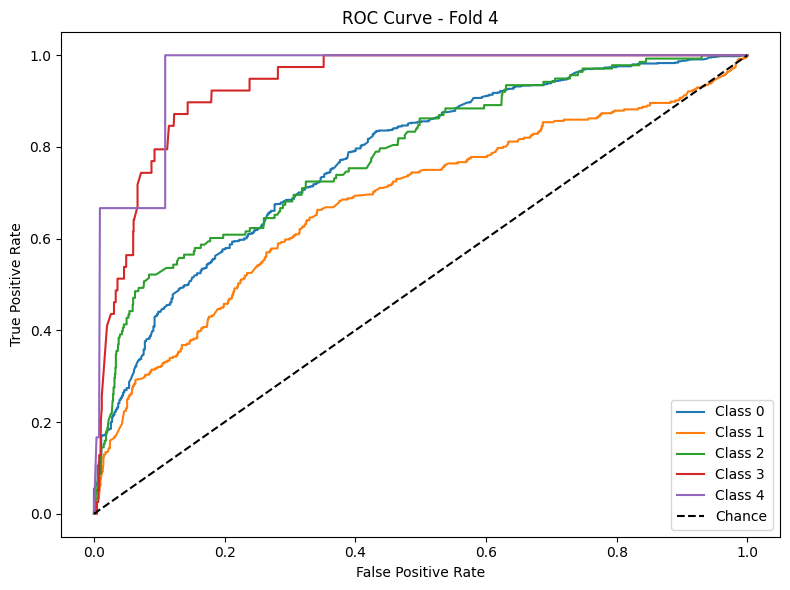

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
553/553 - 15s - 27ms/step - accuracy: 0.5221 - loss: 1.0719 - val_accuracy: 0.4044 - val_loss: 1.1314
Epoch 2/30
553/553 - 4s - 7ms/step - accuracy: 0.6771 - loss: 0.8188 - val_accuracy: 0.5780 - val_loss: 1.0866
Epoch 3/30
553/553 - 4s - 7ms/step - accuracy: 0.7050 - loss: 0.7734 - val_accuracy: 0.6066 - val_loss: 1.0201
Epoch 4/30
553/553 - 4s - 7ms/step - accuracy: 0.7185 - loss: 0.7432 - val_accuracy: 0.6073 - val_loss: 1.0125
Epoch 5/30
553/553 - 4s - 7ms/step - accuracy: 0.7213 - loss: 0.7260 - val_accuracy: 0.6573 - val_loss: 0.9743
Epoch 6/30
553/553 - 4s - 7ms/step - accuracy: 0.7330 - loss: 0.7088 - val_accuracy: 0.6177 - val_loss: 0.9909
Epoch 7/30
553/553 - 4s - 7ms/step - accuracy: 0.7326 - loss: 0.6997 - val_accuracy: 0.6235 - val_loss: 0.9924
Epoch 8/30
553/553 - 4s - 7ms/step - accuracy: 0.7390 - loss: 0.6873 - val_accuracy: 0.6235 - val_loss: 0.9708
Epoch 9/30
553/553 - 4s - 7ms/step - accuracy: 0.7409 - loss: 0.6821 - val_accuracy: 0.6216 - val_loss: 0.9863

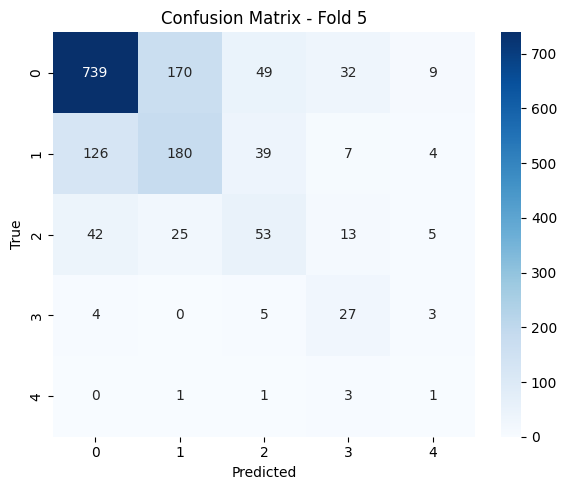

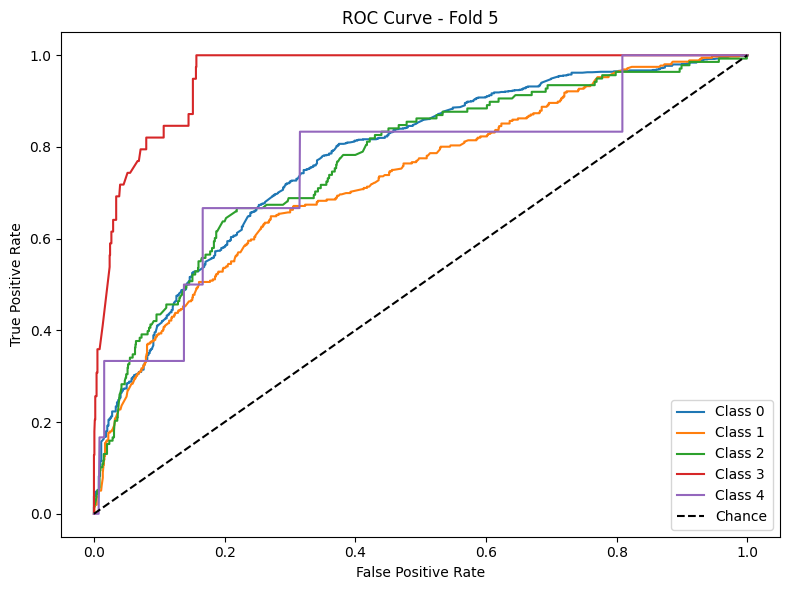


Average Accuracy: 0.6285
Average F1 Macro: 0.4285
Average AUC: 0.8082


In [8]:
# from tensorflow.keras.models import save_model  # không bắt buộc nhưng rõ ràng

phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"

    # ✅ Lưu model Keras
    model.save(f"best_model_{temp}_phase{i}.h5")

    # ✅ Lưu scaler sklearn
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")

    results[f"phase{i}"] = metrics


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       568
           1       0.29      0.35      0.32        63
           2       0.21      0.23      0.22        43
           3       0.12      0.07      0.09        15
           4       0.00      0.00      0.00         9

    accuracy                           0.78       698
   macro avg       0.30      0.31      0.30       698
weighted avg       0.77      0.78      0.77       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


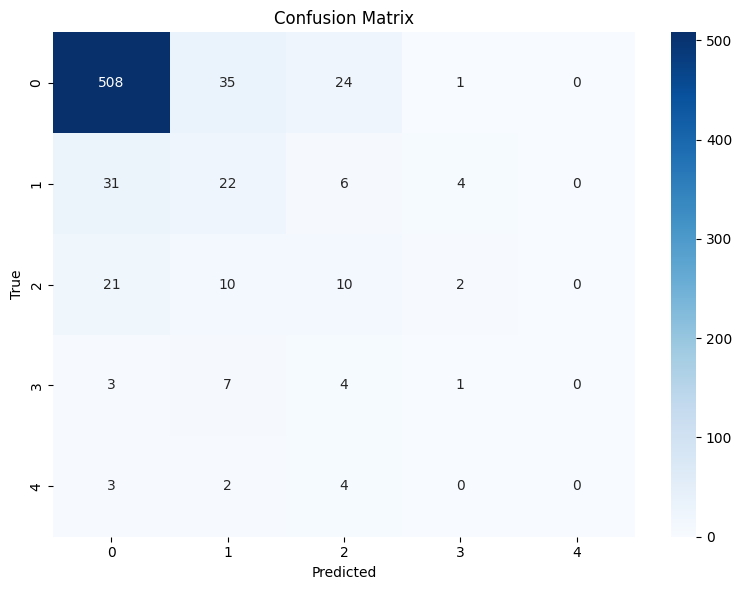


Test AUC (macro-average, OVR): 0.6947


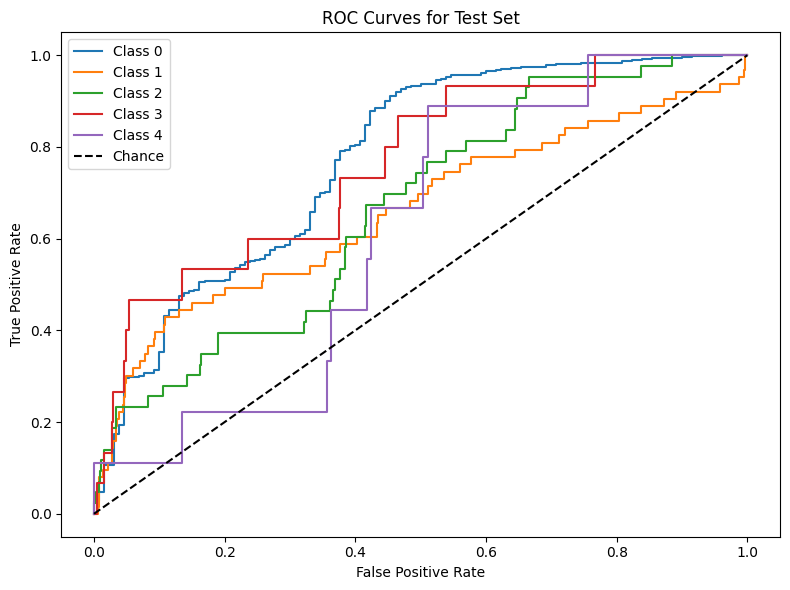

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       544
           1       0.25      0.14      0.18        59
           2       0.26      0.21      0.24        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.81       668
   macro avg       0.28      0.26      0.27       668
weighted avg       0.75      0.81      0.78       668



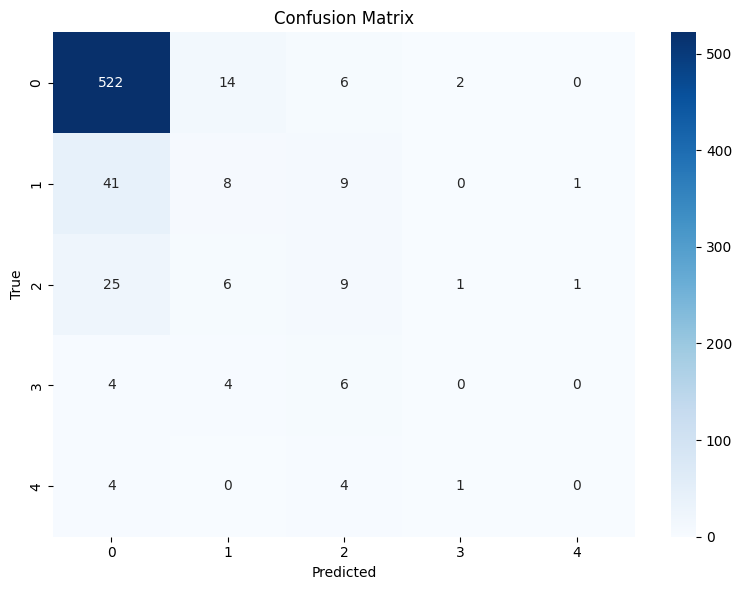


Test AUC (macro-average, OVR): 0.6638


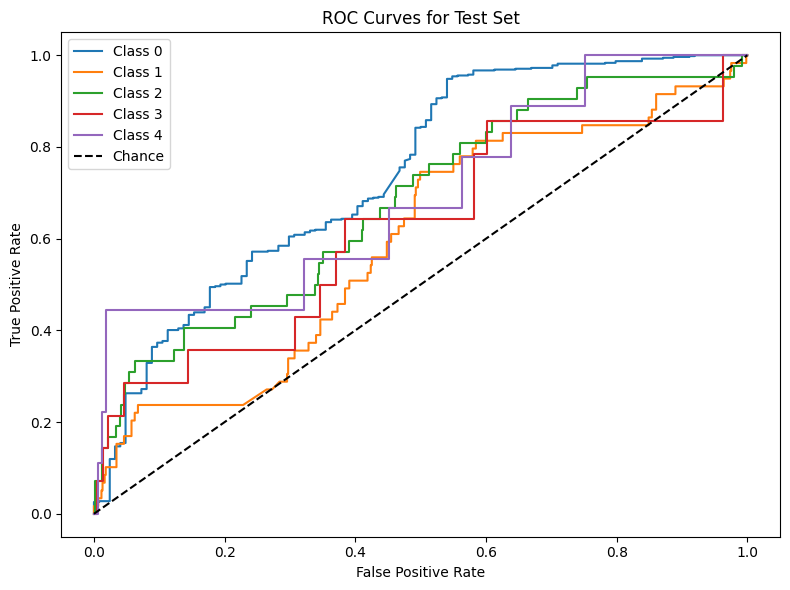

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       455
           1       0.24      0.31      0.27        52
           2       0.29      0.17      0.22        29
           3       0.20      0.20      0.20        10
           4       0.00      0.00      0.00         8

    accuracy                           0.78       554
   macro avg       0.32      0.32      0.32       554
weighted avg       0.77      0.78      0.78       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


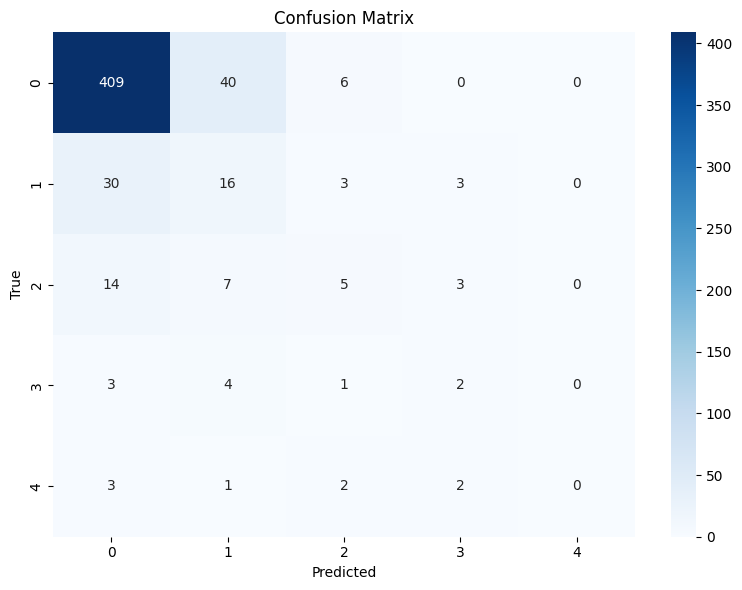


Test AUC (macro-average, OVR): 0.6910


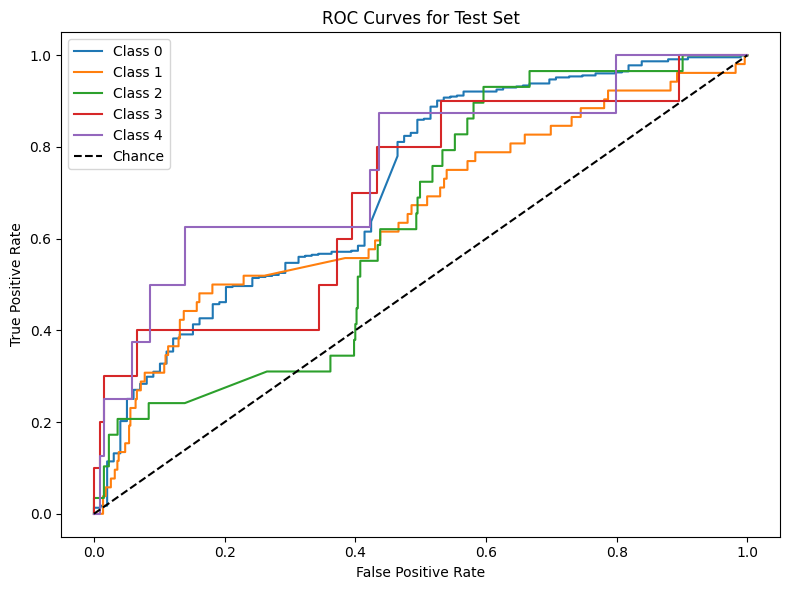

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.52      0.65       395
           1       0.05      0.25      0.09        40
           2       0.21      0.38      0.27        24
           3       0.00      0.00      0.00        10
           4       0.33      0.12      0.18         8

    accuracy                           0.47       477
   macro avg       0.29      0.25      0.24       477
weighted avg       0.72      0.47      0.56       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


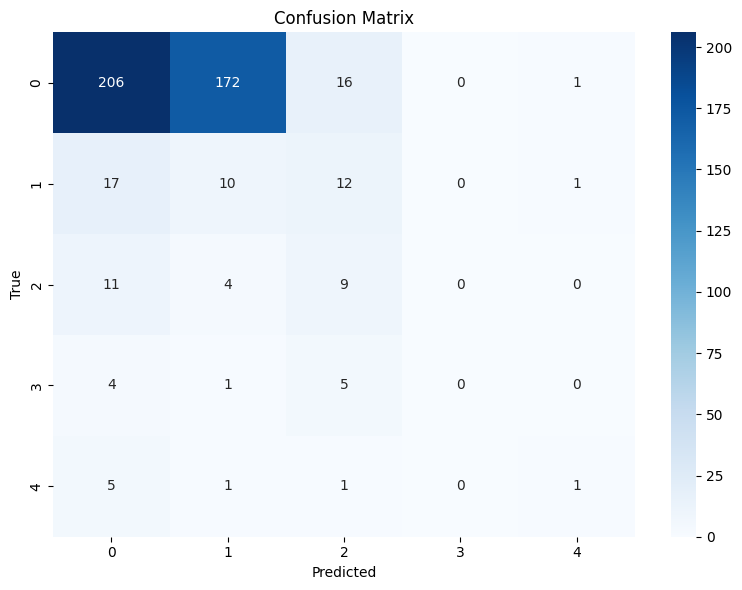


Test AUC (macro-average, OVR): 0.5904


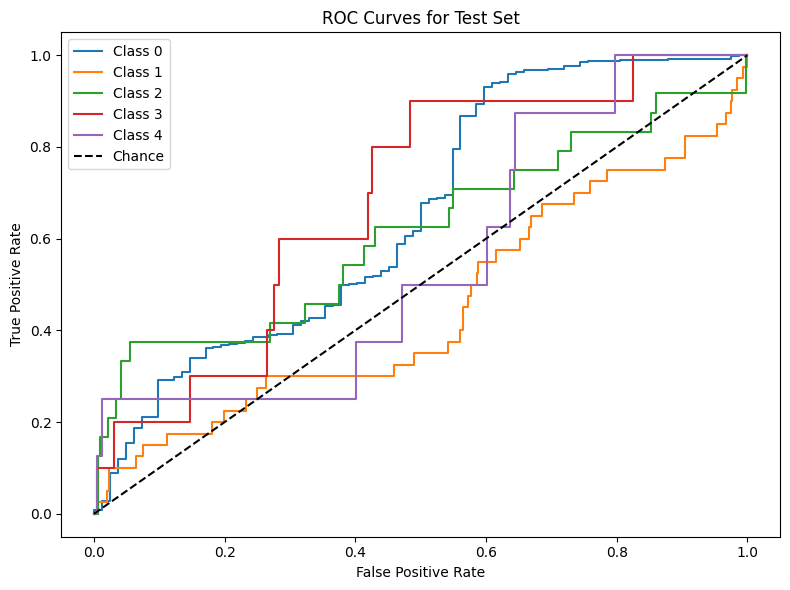

In [9]:
from tensorflow.keras.models import load_model  # đảm bảo đã import đúng ở nơi dùng

# temp = "sample"  # hoặc "no_sample" — giống lúc bạn lưu model

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'

    # ✅ Đường dẫn đúng cho mô hình Keras .h5
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.h5'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'

    # ✅ Đường dẫn mapping
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # ✅ Gọi hàm dự đoán đã tương thích với LSTM
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
